# Repeating Every Experiment & Assessment: 2.5D Version



##### <center> <i> <span style="color:green"> Before we start... </span> </i> </center>

As the title indicates, I'll be exploring results of using 2.5D classification, and comparing them with the replication of slices, in order to ascertain whether this approach is successful. 

Of course, these results will most likely be quite specific to my data set and methodologies, and will only represent a direct comparison and quality of my own methods.

In order to maintain consistent cross-analysis results contrasts, each experiment will retain its original train-test-validation split and ResNet setup (architecture, settings, etc.).

Additionally, I'll be avoiding some experimental comparisons, as they provided results that are guaranteed to be identical throughout both <span style="color:#2377c4"> 2D (represented in blue) </span> and <span style="color:orange"> 2.5D (represented in orange)</span> classification. For example, I will not be using HRCT as the test split, nor testing whether the pure or conservative approach is best for best epoch choice. 

Still, all of this implies several code replications and re-executions. For this reason, I chose to display results in the form of a small report, with indexes and numbered titles, in order to facilitate comprehension and analysis.

---

# Table of Contents

- [1. Data Augmentation vs No Augmentation](#1-data-augmentation-vs-no-augmentation)
  - [1.1 Concept Overview](#11-concept-overview)
  - [1.2 Data Augmentation vs No Augmentation](#13-25d-execution-of-data-augmentation-vs-no-augmentation)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>

  - [1.3 Threshold Selection and Model Choice](#12-threshold-selection-and-model-choice)
  - [1.4 Comparison with 2D](#14-comparison-with-2d)

- [2. Patient-wise Classification Methods](#2-patient-wise-classification-methods)
  - [2.1 Concept Overview](#21-concept-overview)
  - [2.2 Patient-wise Classification Methods](#23-25d-execution-of-patient-wise-classification-methods)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [2.3 Threshold Selection and Model Choice](#22-threshold-selection-and-model-choice)
  - [2.4 Comparison with 2D](#24-comparison-with-2d)

- [3. Slice-level Feature-wise Classification](#3-slice-level-feature-wise-classification)
  - [3.1 Concept Overview](#31-concept-overview)
  - [3.2 Slice-level Feature-wise Classification](#33-25d-execution-of-slice-level-feature-wise-classification)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [3.3 Threshold Selection and Model Choice](#32-threshold-selection-and-model-choice)
  - [3.4 Comparison with 2D](#34-comparison-with-2d)

- [4. Conclusion](#4-conclusion)
  - [4.1 Methodology for Plots](#meth)

<br>

---

<a name="1-data-augmentation-vs-no-augmentation"></a>
## 1. Data Augmentation vs No Augmentation

This section will be dedicated to assess whether the 2.5D model can outperform the 2D model. In order to do so, the first step is to run both resnets with the same configuration, architecture and data split. (only because the original ResNet was only trained for 50 epochs, and is therefore not directly comparable).


<a name="11-concept-overview"></a>
### 1.1 Concept Overview  

For detailed information on augmentations, please refer to directory `3 - resnetTesting`.



<a name="13-25d-execution-of-data-augmentation-vs-no-augmentation"></a>
### 1.2 Data Augmentation vs No Augmentation  


The dictionary below will be used to save relevant metadata and models, with structure:

```py

results_aug["method"] = [best_epoch, train_loss, best_val_loss, model]

```

In [1]:
results_aug = {}

In [2]:
from newDimUtils import *

import matplotlib.colors as mcolors

# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


SliceID  Class
0  101__CT-0002-0001.npy      0
1  101__CT-0002-0002.npy      0
2  101__CT-0002-0003.npy      0
3  101__CT-0002-0004.npy      0
4  101__CT-0002-0005.npy      0

<center> 

#### <span style="color:#2377c4"> 2D, no Augmentations </span>

</center>

In [183]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            # idx represents index
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")
            slice_id = self.img_labels.iloc[idx, 0]
            patient_id = getPatientID(slice_id)

            # Load the .npy file
            image = np.load(img_path)
            
            #image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Already has resize prior to augments
            if self.albumentations:
                stacked_aug = self.albumentations(image=image)
                image = stacked_aug['image']

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)

            
            return image, label, patient_id

In [4]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Needed for classification
test_dataset_2d_noAug = test_dataset
val_dataset_2d_noAug = val_dataset

SliceID at index 1267: 78__CT-9830-0009.npy
(224, 224, 3)


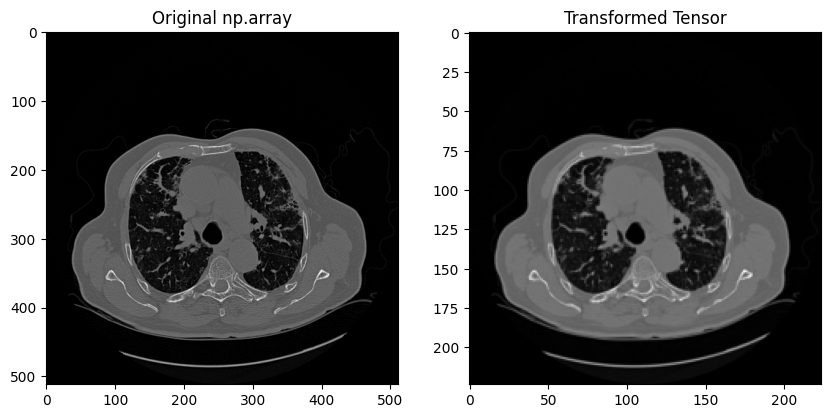

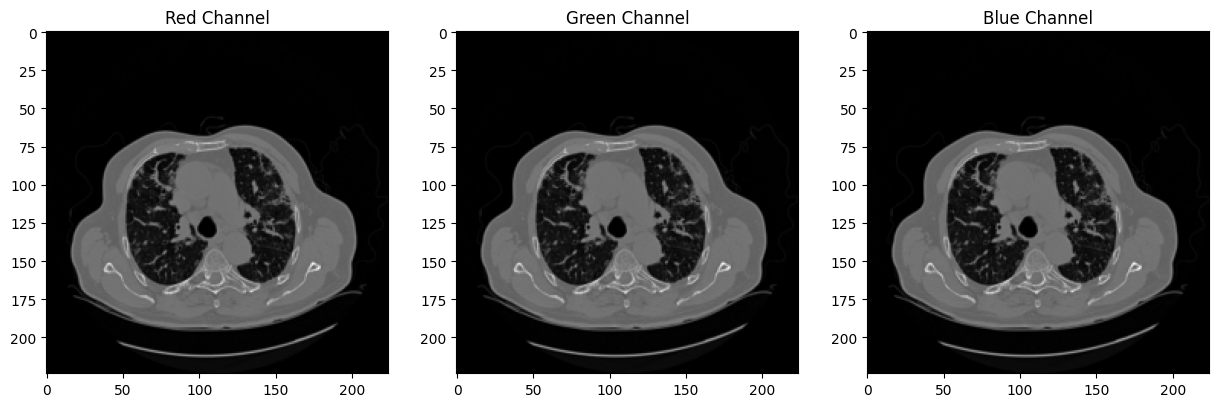

In [5]:
tensorVSnp(train_dataset, df_fibrosis)

In [6]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\2209417091.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_N

In [7]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [8]:
# Save to dict for result comparison
results_aug["2d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:#2377c4"> 2D, with Augmentations </span>

</center>

In [184]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for eval

val_dataset_2d_Aug = val_dataset
test_dataset_2d_Aug = test_dataset

SliceID at index 380: 137__CT-0724-0004.npy
(224, 224, 3)


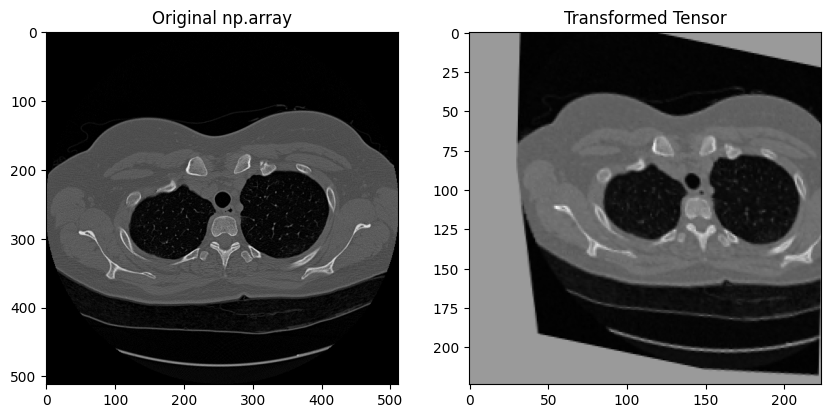

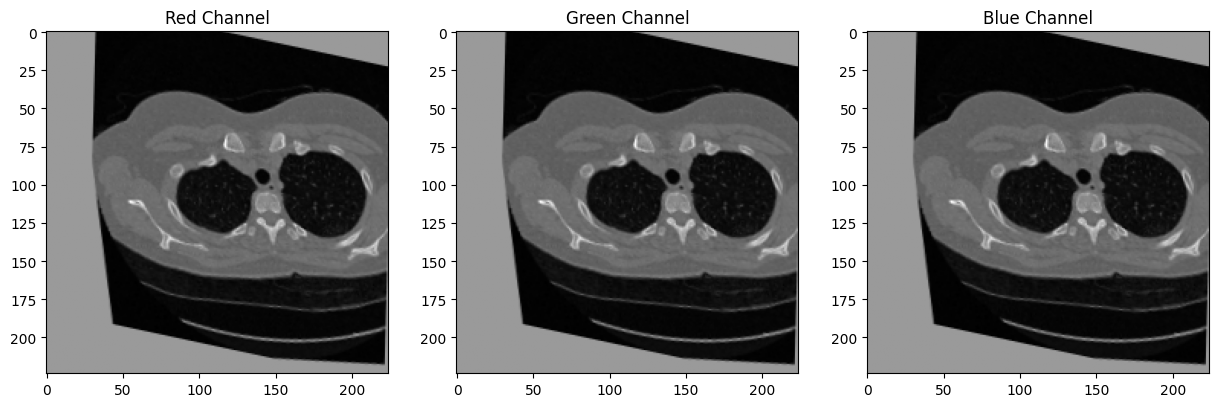

In [10]:
tensorVSnp(train_dataset, df_fibrosis)

In [11]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\2772197137.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_a

In [12]:
ans = str(input("Do you wish to save?"))

#ans = "yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [13]:
# Save to dict for result comparison
results_aug["2d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, no Augmentations </span>

</center>

In [14]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label, patient_id

In [15]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for eval 

val_dataset_2_5d_noAug = val_dataset
test_dataset_2_5d_noAug = test_dataset

SliceID at index 612: 160__CT-1070-0026.npy
(224, 224, 3)


C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = os.path.join(self.img_dir, row[0])
C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]
C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return img, label, row[0]


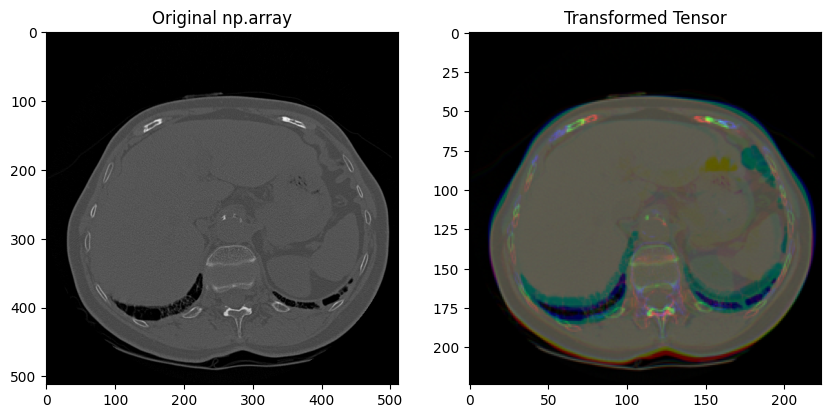

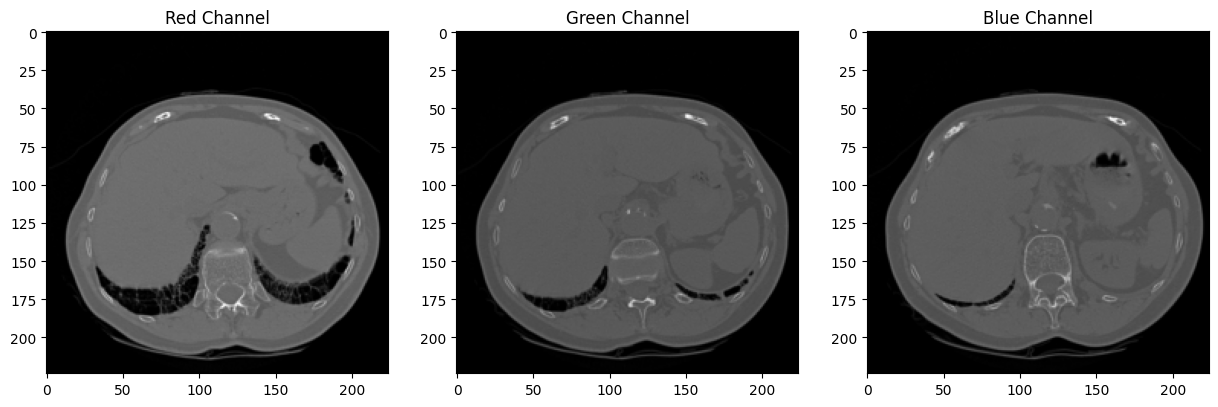

In [16]:
tensorVSnp(train_dataset, df_fibrosis)

In [17]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2_5d.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\1996765398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata_N

In [18]:
ans = str(input("Do you wish to save?"))
#ans = "yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2_5d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [19]:
results_aug["2_5d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, with Augmentations </span>

</center>

In [20]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 163: 121__CT-0844-0018.npy
(224, 224, 3)


C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = os.path.join(self.img_dir, row[0])
C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]
C:\Users\hasht\AppData\Local\Temp\ipykernel_2624\448409968.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return img, label, row[0]


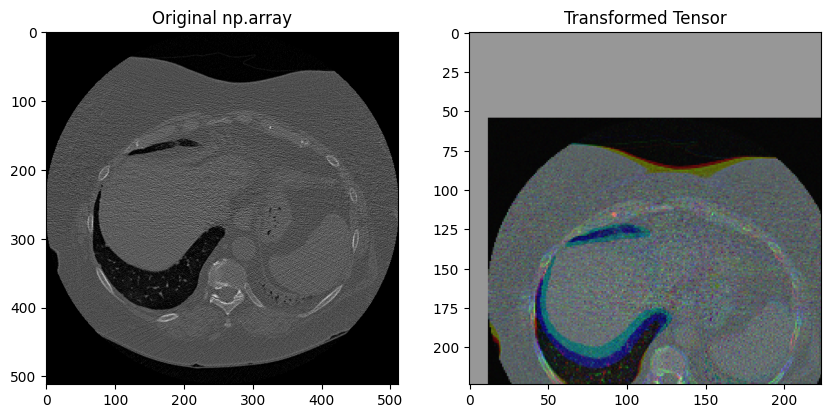

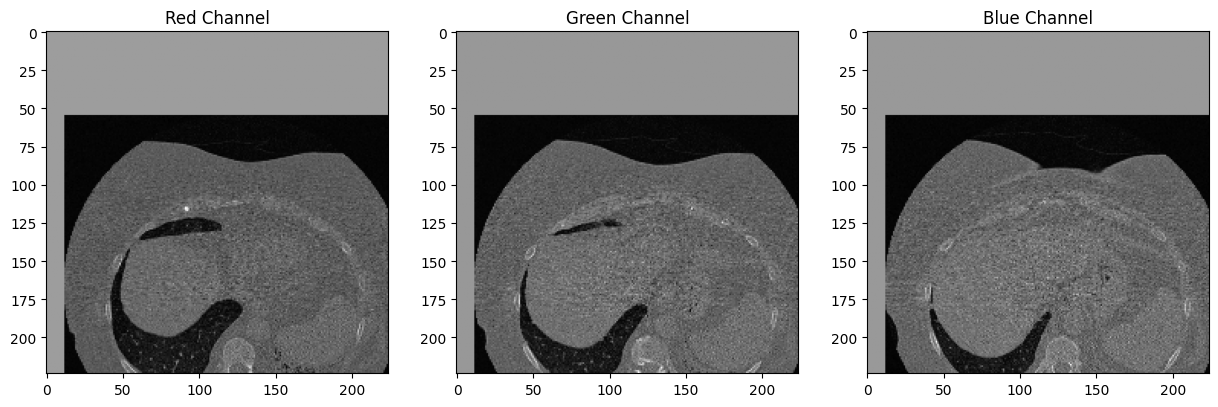

In [21]:
tensorVSnp(train_dataset, df_fibrosis)

In [22]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))
#ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2_5d.pkl"))


else: print("Invalid answer, try again.")

Invalid answer, try again.


In [23]:
#ans = str(input("Do you wish to save?"))
ans="yes"
if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2_5d.pkl"))

else: print("DID NOT SAVE")

In [24]:
# Save to dict for result comparison
results_aug["2_5d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<a name="12-threshold-selection-and-model-choice"></a>
### 1.3 Threshold Selection and Model Choice  



In [185]:
def getAllROCs(results_dict, val_dataset, validation=True):
    threshold_dict = {}
    all_rocs = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    subplot_positions = {}

    for key in results_dict:
        # Determine row
        if "2_5" in key:
            row = 1  
            if not validation and "no" in key: val_dataset = test_dataset_2_5d_noAug
            if not validation and not ("no" in key): val_dataset = test_dataset
        else: 
            row = 0
            if validation: val_dataset = val_dataset_2d_noAug
            elif "no" in key: val_dataset = test_dataset_2d_noAug
            else: val_dataset = test_dataset_2d_Aug
        # Determine column
        col = 0 if ("no" in key or "No" in key) else 1
        subplot_positions[key] = (row, col)
    
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        for key, value in tqdm(results_dict.items()):
            model = value[3]
            model.to(device)
            model.eval()

            all_labels, all_scores = [], []

            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    probs = F.softmax(outputs, dim=1)[:, 1]

                    all_scores.extend(probs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        distances = np.sqrt((fpr) ** 2 + (1 - tpr) ** 2)
        best_idx = np.argmin(distances)
        best_threshold = thresholds[best_idx]

        threshold_dict[key] = best_threshold
        all_rocs[key] = (fpr, tpr, roc_auc, best_threshold, best_idx)

        # Subplot position
        row, col = subplot_positions[key]
        ax = axs[row][col]

        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Threshold = {best_threshold:.2f}')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(key)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Combined plot
    plt.figure(figsize=(8, 6))
    for key, (fpr, tpr, roc_auc, best_threshold, best_idx) in all_rocs.items():
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return threshold_dict


In [186]:
def darken_color(color, factor=0.7):
    """Darken a color by a given factor (0 to 1)."""
    rgb = mcolors.to_rgb(color)
    return tuple(np.clip([c * factor for c in rgb], 0, 1))

def plotAllLossCurves(results_dict):
    num_models = len(results_dict)
    plt.figure(figsize=(12, 10))

    # Individual subplots (2 rows × 2 cols)
    for idx, (key, values) in enumerate(results_dict.items()):
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        plt.subplot(2, 2, idx + 1)
        plt.plot(epochs, train_loss, label='Train Loss', linestyle='-', marker='o')
        plt.plot(epochs, val_loss, label='Val Loss', linestyle='--', marker='x')
        plt.plot(best_epoch, best_val_loss, 'X', color='purple', markersize=10, label='Best Epoch')

        plt.title(key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- Combined Plot -----
    plt.figure(figsize=(10, 6))

    # Use a predefined color cycle (can also use seaborn or matplotlib colormaps)
    color_cycle = plt.cm.tab10.colors  # 10 distinct colors
    keys = list(results_dict.keys())
    color_map = {key: color_cycle[i % len(color_cycle)] for i, key in enumerate(keys)}

    for key in keys:
        values = results_dict[key]
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        base_color = color_map[key]
        darker_color = darken_color(base_color)

        # Plot both curves in the same color
        plt.plot(epochs, train_loss, color=base_color, linestyle='-', alpha=0.6)
        plt.plot(epochs, val_loss, color=base_color, linestyle='--', alpha=0.9)

        # Plot the 'best epoch' as a darker marker
        plt.plot(best_epoch, best_val_loss, 'X', color=darker_color, markersize=10)

    # Add single legend entry per method
    for key in keys:
        plt.plot([], [], color=color_map[key], label=key)

    plt.title('All Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


<center>

#### Validation ROC

</center>

In [187]:
def getROC(model, val_dataset, method_name): 

    all_labels, all_scores = [], []
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patientID in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Translate logits to Class 1 probabilities using softmax
            # (pulls column 1 values and assigns probabilities)
            probs = F.softmax(outputs, dim=1)[:, 1]  

            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]


    # ---------- Display and Results ---------- 

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print("Area Under Curve:", roc_auc)
    print("Best Threshold (closest to (0,1)):", best_threshold)

    return {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "thresholds": thresholds,
    "best_threshold": best_threshold,
    "best_idx": best_idx,
    "method_name": method_name  
    }

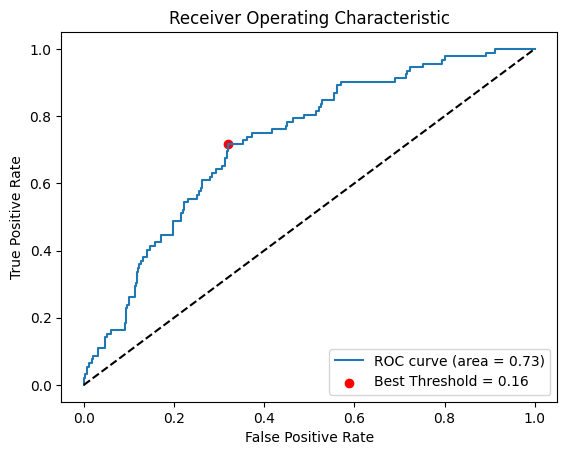

Area Under Curve: 0.7261767876392382
Best Threshold (closest to (0,1)): 0.15959369


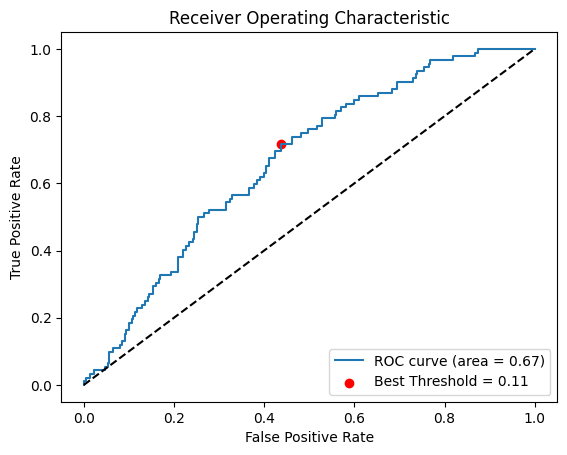

Area Under Curve: 0.6664750269493354
Best Threshold (closest to (0,1)): 0.11265797


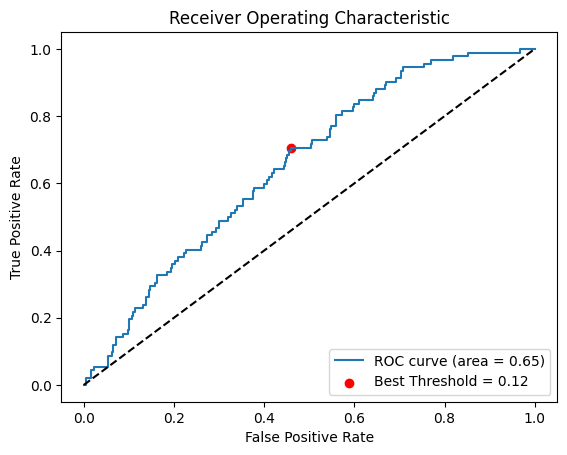

Area Under Curve: 0.654599353215954
Best Threshold (closest to (0,1)): 0.118744634


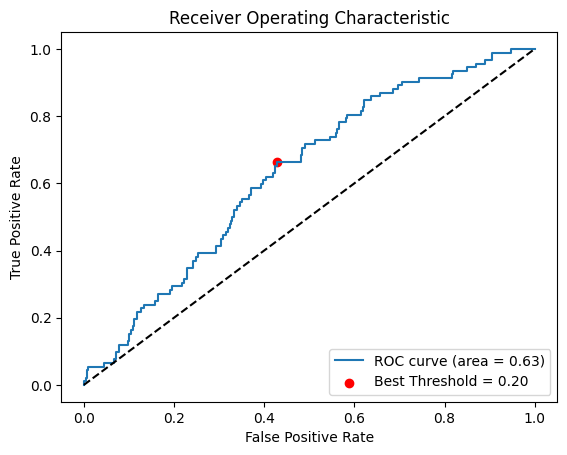

Area Under Curve: 0.6306503772906935
Best Threshold (closest to (0,1)): 0.19996579


In [188]:
warnings.filterwarnings("ignore")

val_roc_results_aug = {}

# Getting each individual result
# 2D
val_roc_results_aug["2d_noAug"] = getROC(results_aug["2d_noAug"][3], val_dataset_2d_noAug, "2d_noAug")
val_roc_results_aug["2d_Aug"] = getROC(results_aug["2d_Aug"][3], val_dataset_2d_Aug, "2d_Aug")
# 2.5D
val_roc_results_aug["2_5d_noAug"] = getROC(results_aug["2_5d_noAug"][3], val_dataset_2_5d_noAug, "2_5d_noAug")
val_roc_results_aug["2_5d_Aug"] = getROC(results_aug["2_5d_Aug"][3], val_dataset, "2_5d_Aug")

In [189]:
def plotCombinedRoc(roc_dict): 
    plt.figure(figsize=(8, 6))
    for label, result in roc_dict.items():
        plt.plot(result["fpr"], result["tpr"], label=f'{label} (AUC = {result["auc"]:.2f})')
        plt.scatter(result["fpr"][result["best_idx"]], result["tpr"][result["best_idx"]], color='red', s=20)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

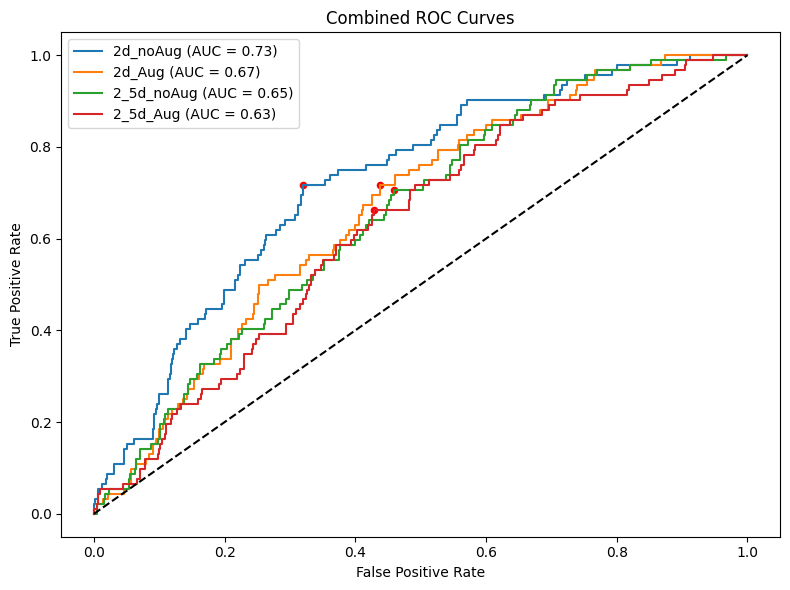

In [190]:
plotCombinedRoc(val_roc_results_aug)

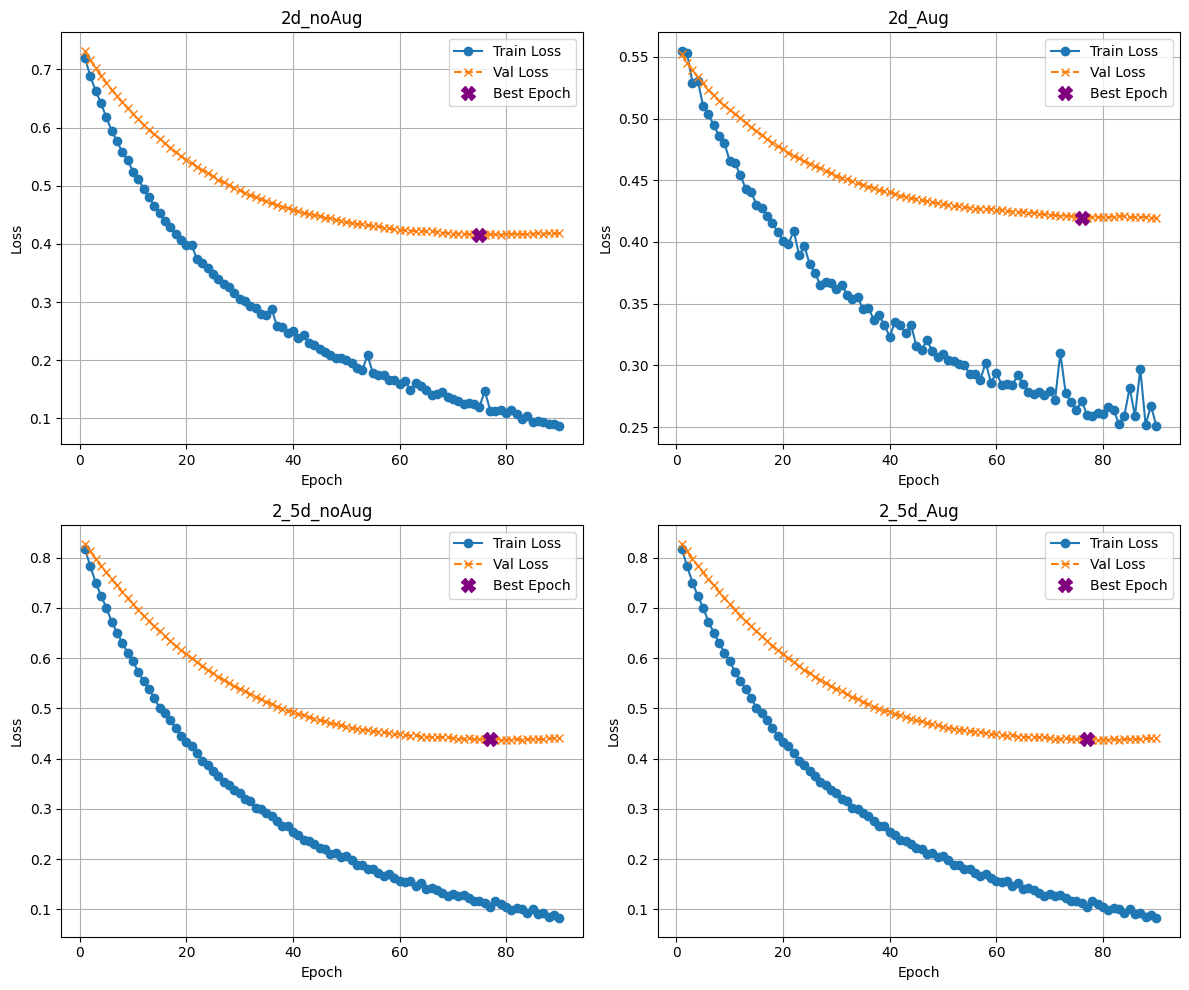

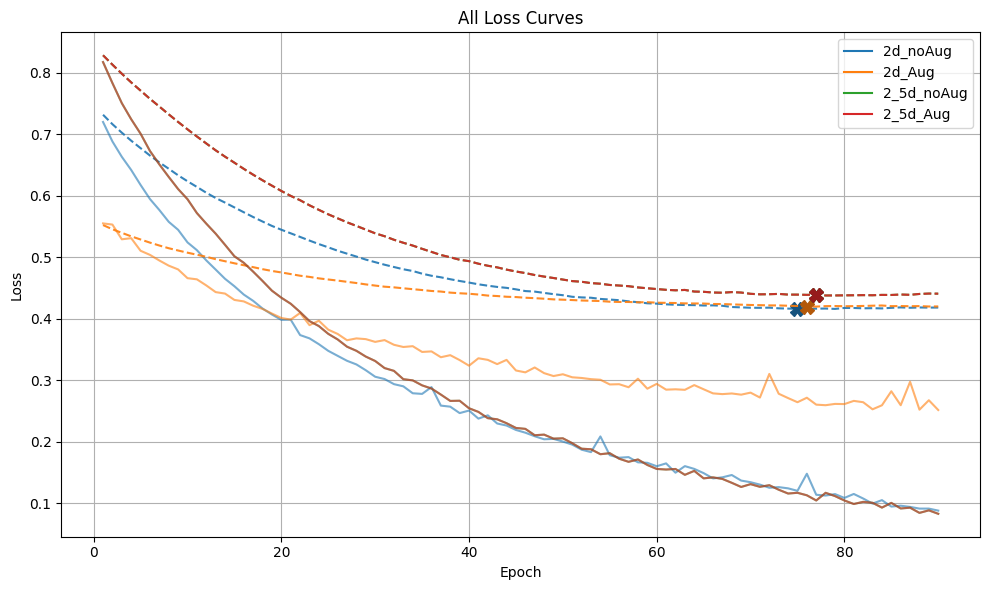

In [191]:
plotAllLossCurves(results_aug)


<a name="14-comparison-with-2d"></a>
### 1.4 Comparison with 2D  

In [192]:
metrics_aug = {}

for key, val in results_aug.items():
    print(f"               Method: {key}\n")
    best_thresh = val_roc_results_aug[key]["best_threshold"]
    if "_5" in key:
        if "no" in key: m_aug = evalResNet(val[3], test_dataset_2_5d_noAug, threshold=best_thresh) # 2.5D, no Aug
        else: m_aug = evalResNet(val[3], test_dataset, threshold=best_thresh) # 2.5D, with Aug
    else: 
        if "no" in key: m_aug = evalResNet(val[3], test_dataset_2d_noAug, threshold=best_thresh) # 2D, no Aug
        else: m_aug = evalResNet(val[3], test_dataset_2d_Aug, threshold=best_thresh) # 2D, with Aug
    metrics_aug[key] = m_aug
    print(" --------------------- \n")

               Method: 2d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 53.64%  (302 in 563)
Accuracy for Class 1: 85.88%  (73 in 85)
Test Accuracy: 57.87%
Weighted Accuracy: 81.59%

 --------------------- 

F1 Score (Macro): 0.519
F1 Score (Weighted): 0.644
F1 Score Class 0: 0.689
F1 Score Class 1: 0.348

 --------------------- 


Confusion Matrix: 
 [[302 261]
 [ 12  73]]
 --------------------- 

               Method: 2d_Aug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 46.36%  (261 in 563)
Accuracy for Class 1: 88.24%  (75 in 85)
Test Accuracy: 51.85%
Weighted Accuracy: 82.67%

 --------------------- 

F1 Score (Macro): 0.475
F1 Score (Weighted): 0.586
F1 Score Class 0: 0.626
F1 Score Class 1: 0.325

 --------------------- 


Confusion Matrix: 
 [[261 302]
 [ 10  75]]
 --------------------- 

               Method: 2_5d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 54.71%  (308 in 563)
Accuracy for Cla

<center>

#### Test ROC

</center>

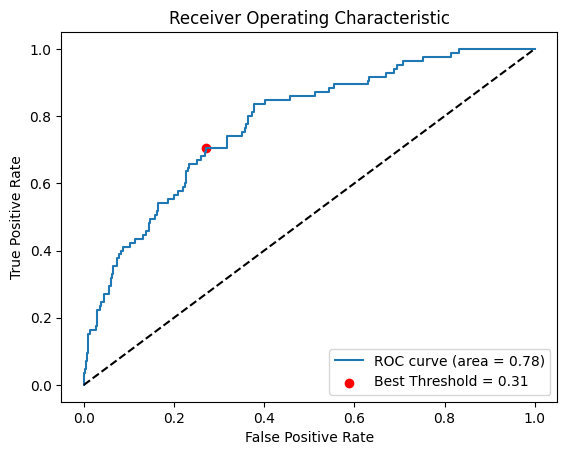

Area Under Curve: 0.779019956117438
Best Threshold (closest to (0,1)): 0.31020853


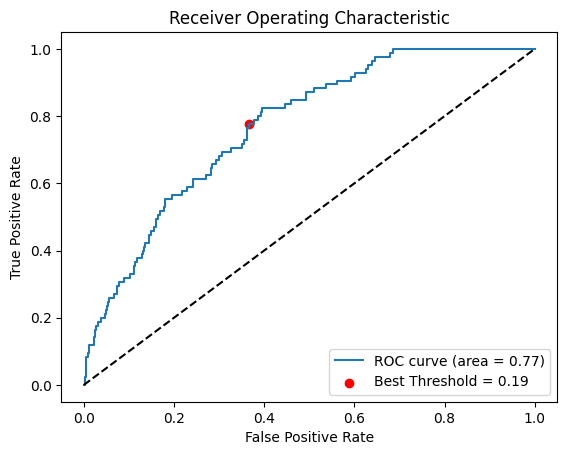

Area Under Curve: 0.769971789781632
Best Threshold (closest to (0,1)): 0.1896438


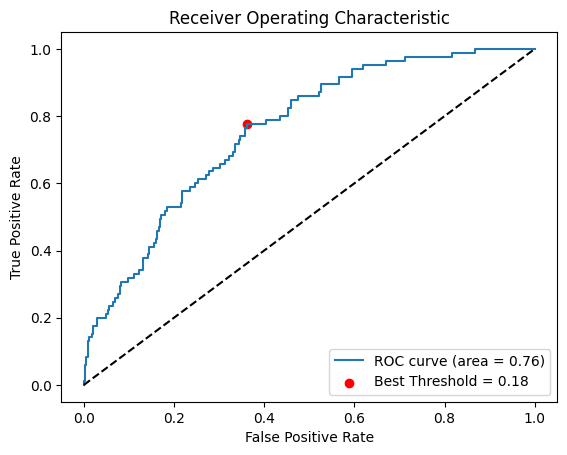

Area Under Curve: 0.7587294953505381
Best Threshold (closest to (0,1)): 0.18300822


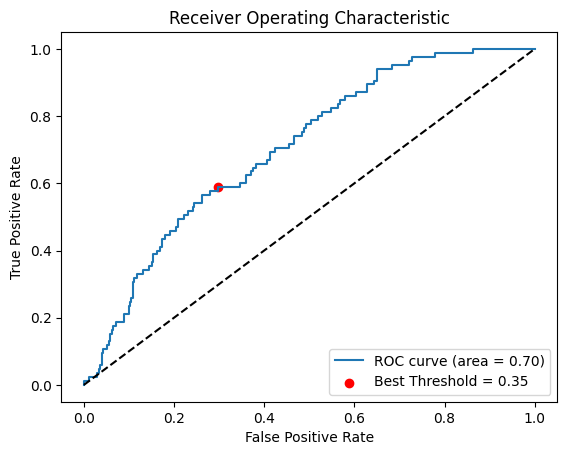

Area Under Curve: 0.704231532755198
Best Threshold (closest to (0,1)): 0.3491083


In [193]:
warnings.filterwarnings("ignore")

test_roc_results_aug = {}

# Getting each individual result
# 2D
test_roc_results_aug["2d_noAug"] = getROC(results_aug["2d_noAug"][3], test_dataset_2d_noAug, "2d_noAug")
test_roc_results_aug["2d_Aug"] = getROC(results_aug["2d_Aug"][3], test_dataset_2d_Aug, "2d_Aug")
# 2.5D
test_roc_results_aug["2_5d_noAug"] = getROC(results_aug["2_5d_noAug"][3], test_dataset_2_5d_noAug, "2_5d_noAug")
test_roc_results_aug["2_5d_Aug"] = getROC(results_aug["2_5d_Aug"][3], test_dataset, "2_5d_Aug")

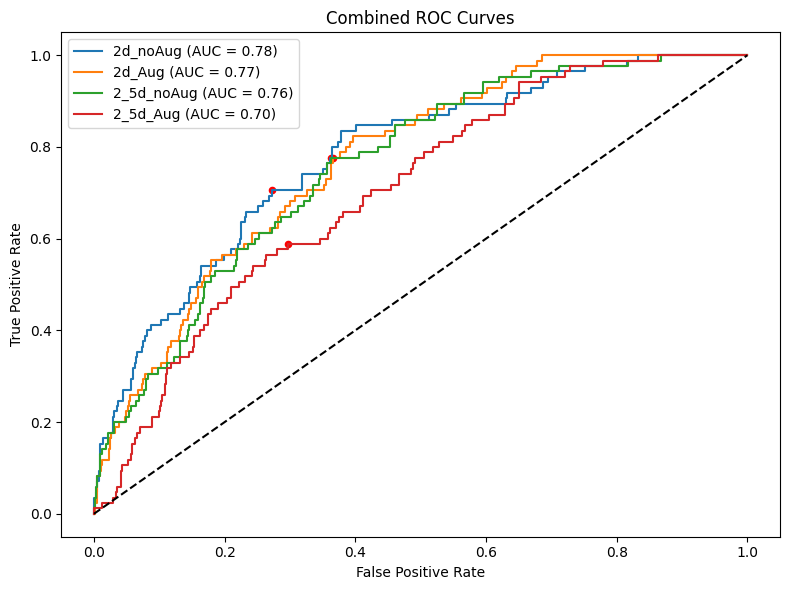

In [194]:
plotCombinedRoc(test_roc_results_aug)

<center>

#### Confusion Matrices

</center>

##### <span style="color:Red"> WARNING !!! </span>

The vertical and horizontal values for the scatterplot are randomly generated, simply for visualization purposes. The goal is to help demonstrate comparison of false positives/negatives relative proportion in the overall decision process:

<center>

| **Side**  | **Outcome** | **Color** | **Explanation**                             |
| --------- | ----------- | --------- | ------------------------------------------- |
| **Left**  | TN          | Green     | Correct healthy prediction                  |
| **Left**  | FP          | Red       | Predicted sick (1), was healthy (0)         |
| **Right** | TP          | Red       | Correct sick prediction                     |
| **Right** | FN          | Green     | Predicted healthy (0), was sick (1)         |

</center>



This means that **the <span style="color:green"> greener the left side </span> of each halved plot is, the better**, and **the same goes for <span style="color:red"> red on the right side </span>**.

In [329]:
def get_points(conf_mat):
    TN, FP = conf_mat[0]
    FN, TP = conf_mat[1]

    # Left side (Class 0): TN (green), FP (red)
    TN_pts = np.column_stack((np.random.uniform(-1, -0.1, TN), np.random.uniform(0, 1, TN)))
    FP_pts = np.column_stack((np.random.uniform(-1, -0.1, FP), np.random.uniform(0, 1, FP)))

    # Right side (Class 1): FN (green), TP (red)
    FN_pts = np.column_stack((np.random.uniform(0.1, 1, FN), np.random.uniform(0, 1, FN)))
    TP_pts = np.column_stack((np.random.uniform(0.1, 1, TP), np.random.uniform(0, 1, TP)))

    return TN_pts, FP_pts, FN_pts, TP_pts

def confMat(dict_results, key1, dict_results2=None, key2=None):
    # Set up keys and dicts
    if dict_results2 is None: dict_results2 = dict_results
    keys = [key1, key2]
    dcts = [dict_results, dict_results2]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    fig.text(0.5, 1, 'Confusion Matrix', fontsize=16, ha='center', va='center')
    fig.text(0.5, 0.48, 'Barplots', fontsize=16, ha='center', va='center')
    

    for col, (key, d) in enumerate(zip(keys, dcts)):
        conf_mat = d[key][8]

        # HEATMAP (Top row)
        ax_heat = axs[0, col]
        colors_arr = ['#fff5eb', '#fdae6b', '#e6550d']  # light to dark orange
        orange_cmap = LinearSegmentedColormap.from_list('custom_orange', colors_arr)
        cmap = 'Blues' if "2d" in key else orange_cmap
        sns.heatmap(conf_mat,
                    annot=True,
                    fmt='d',
                    cmap=cmap,
                    xticklabels=['Pred 0', 'Pred 1'],
                    yticklabels=['True 0', 'True 1'],
                    cbar=False,
                    ax=ax_heat)
        ax_heat.set_title(f"Confusion Matrix: {key}", fontsize=12)
        ax_heat.set_xlabel("Predicted Label")
        ax_heat.set_ylabel("True Label")

        # BARPLOT (Bottom row)
        ax_bar = axs[1, col]
        TN, FP = conf_mat[0]
        FN, TP = conf_mat[1]

        labels = ['TN', 'FP', 'TP', 'FN']
        values = [TN, FP, TP, FN]
        colors = ['green', 'red', 'red', 'green']

        ax_bar.bar(labels, values, color=colors)
        ax_bar.set_title(f"{key}", fontsize=12)
        ax_bar.set_xlabel('← Class 0 (Green)     |     (Red) Class 1 →')
        ax_bar.set_ylabel("Count")
        ax_bar.axvline(1.5, color='black', linestyle='--')
        ax_bar.set_ylim(0, max(values) * 1.2)  # Add headroom
        
    plt.tight_layout()  
    plt.subplots_adjust(hspace=0.43) 
    plt.show()

def confMatScatter(dict_results, key1, dict_results2=None, key2=None):

    # Set up keys and dicts
    if dict_results2 is None: dict_results2 = dict_results
    keys = [key1, key2]
    dcts = [dict_results, dict_results2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for col, (key, d) in enumerate(zip(keys, dcts)):
        conf_mat = d[key][8]

        TN_pts, FP_pts, FN_pts, TP_pts = get_points(conf_mat)

        # SCATTER PLOT 
        ax_scatter = axs[col]
        ax_scatter.scatter(*TN_pts.T, color='green', alpha=0.6) # label='TN'
        ax_scatter.scatter(*FP_pts.T, color='red', alpha=0.6)   # label='FP'
        ax_scatter.scatter(*FN_pts.T, color='red', alpha=0.6)   # label='FN'
        ax_scatter.scatter(*TP_pts.T, color='green', alpha=0.6) # label='TP'
        ax_scatter.axvline(0, color='black', linestyle='--')
        ax_scatter.set_title(key, fontsize=12)
        ax_scatter.set_xlabel('← Class 0 (Green)     |     (Red) Class 1 →')
        ax_scatter.grid(True)
        ax_scatter.set_xticks([])  # Remove x-axis numbers
        ax_scatter.set_yticks([])  # Remove y-axis numbers
        if col == 1:
            ax_scatter.legend()

    plt.tight_layout()  
    plt.show()

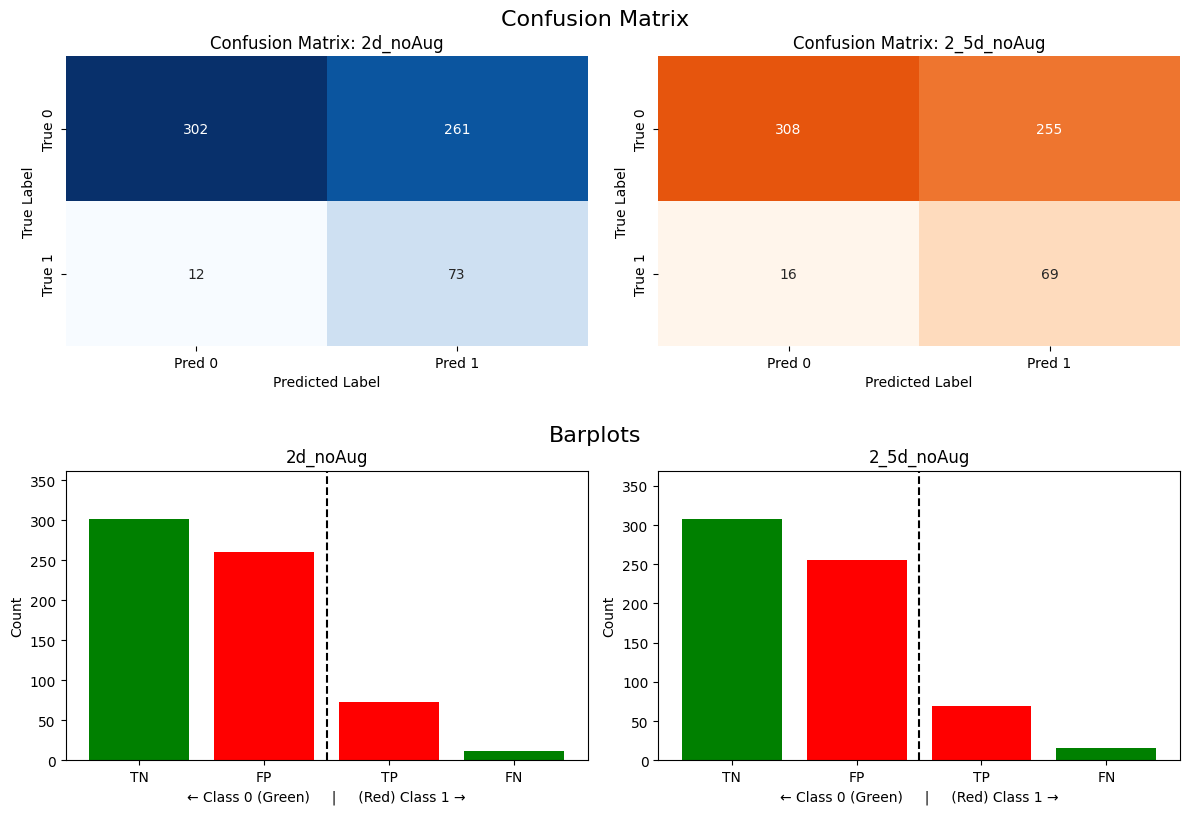

In [330]:
confMat(metrics_aug, key1="2d_noAug", key2="2_5d_noAug")

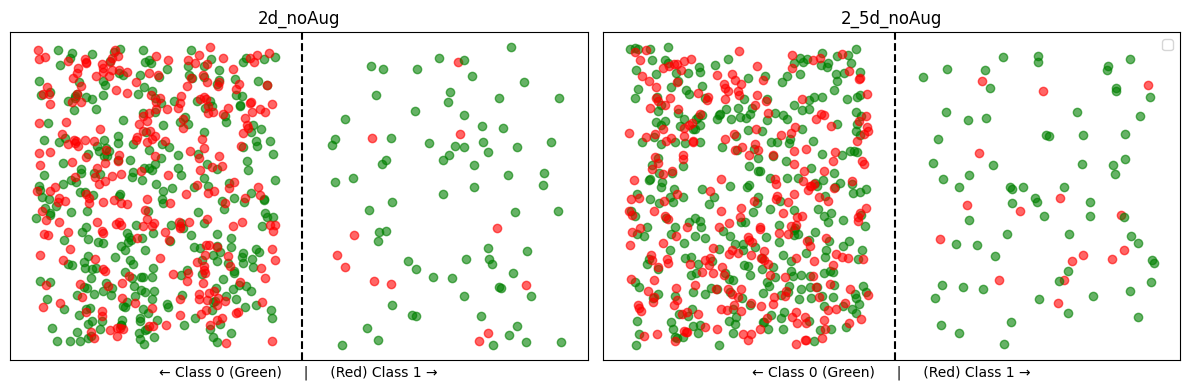

In [331]:
confMatScatter(metrics_aug, key1="2d_noAug", key2="2_5d_noAug")

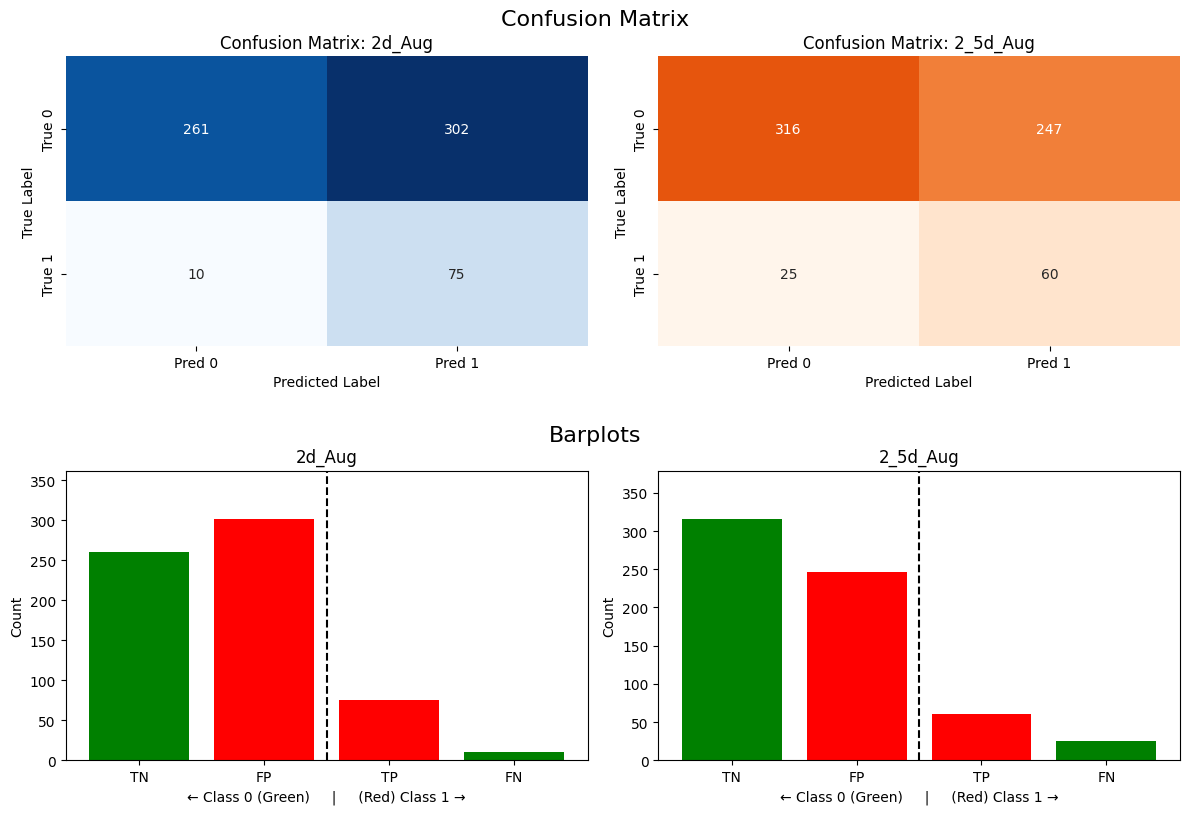

In [332]:
confMat(metrics_aug, key1="2d_Aug",key2="2_5d_Aug")

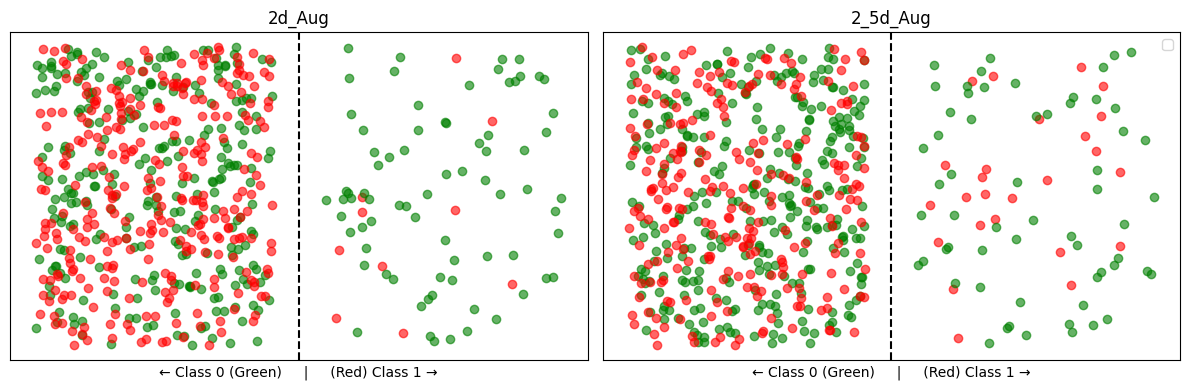

In [333]:
confMatScatter(metrics_aug, key1="2d_Aug",key2="2_5d_Aug")

---

<a name="2-patient-wise-classification-methods"></a>

## 2. Patient-wise Classification Methods




<a name="21-concept-overview"></a>
### 2.1 Concept Overview  

For detailed information on patient aggregation methods, please refer to directory `4.2 - evalAsPatient`.




<a name="23-25d-execution-of-patient-wise-classification-methods"></a>
### 2.2 Patient-wise Classification Methods  



In [104]:
results_patient = {}
THRESHOLD_EVAL = 0.26189378

<center> 

#### <span style="color:#2377c4"> 2D, Patient-Wise </span>

</center>

In [105]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)

        return image, label, patient_id

In [106]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for classification

test_dataset_patient = test_dataset
val_dataset_patient = val_dataset

SliceID at index 1466: 154__CT-INSPIRIUM-6410__CT-6410-0003.npy
(224, 224, 3)


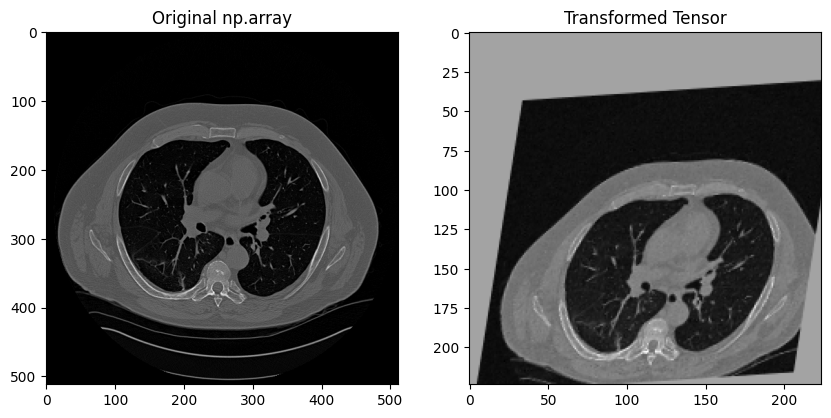

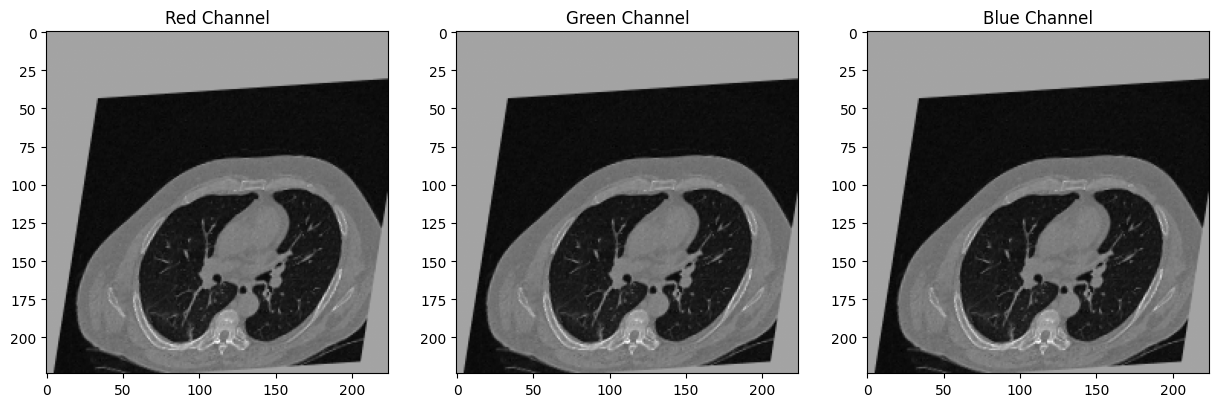

In [107]:
tensorVSnp(train_dataset, df_fibrosis)

In [108]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"


# Read file
checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

# Load values
best_epoch = checkpoint["epoch"]
custom_loss = checkpoint["train_loss"]
custom_val_loss = checkpoint["val_loss"]

resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val.pkl"))

In [109]:
results_patient["2d"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

In [110]:
def getROCAggregate(model, dataset, threshold, aggregate_criteria="mean", show_plot=True, method="2d_"): 

    all_labels, all_scores = [], []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Needed for patient-wise classification
    patient_prob = {}
    patient_class = {}

    model.eval()
    with torch.no_grad():
        for images, labels, patient_id in loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = model(images)

            # Translate logits to probabilities using softmax
            # and then chooses only values for Class 1 (0 or 1)
            probs = F.softmax(outputs, dim=1)[:, 1] 
        
            # Associate probabilities/values to dictionary for each patient
            for pid, prob, label in zip(patient_id, probs.tolist(), labels.tolist()):
                if pid not in patient_prob:
                    patient_prob[pid] = []  # Initializes key:value pair if it doesn't exist
                    patient_class[pid] = 0  # Sets classification as 0 until otherwise

                patient_prob[pid].append(prob)  # Adds probability to list
                
                # Label aggregation condition
                if label == 1: patient_class[pid] = 1 # Updates Classification
    
    # 2. After pulling every slice value for every patient, apply aggregate_criteria
    # and evaluate the aggregated values using criteria-specific conditions
    for id, prob_list in patient_prob.items():
        if aggregate_criteria == "mean":
            final_prob = np.mean(prob_list)
        
        # Absolute and Relative slice ammount thresholds (number of slices vs ratio)
        elif aggregate_criteria == "ratio" or aggregate_criteria == "n_is_enough":
            
            # Obtain fibrosis ratio
            ctr0,ctr1 = 0,0
            for prob in prob_list:
                slice_class = int(prob >= threshold)
                if slice_class == 1: ctr1 +=1
                else: ctr0 +=1

            final_prob = (ctr1/(ctr1+ctr0)) if aggregate_criteria == "ratio" else ctr1

        label = patient_class[id]

        #  y_true, y_pred -> all_scores, all_labels
        all_labels.append(label)
        all_scores.append(final_prob)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    if show_plot:
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold for method {aggregate_criteria} = {best_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

        print("Area Under Curve:", roc_auc)
        print("Best Threshold (closest to (0,1)):", best_threshold)

    return {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "thresholds": thresholds,
    "best_threshold": best_threshold,
    "best_idx": best_idx,
    "method_name": method+aggregate_criteria  
    }

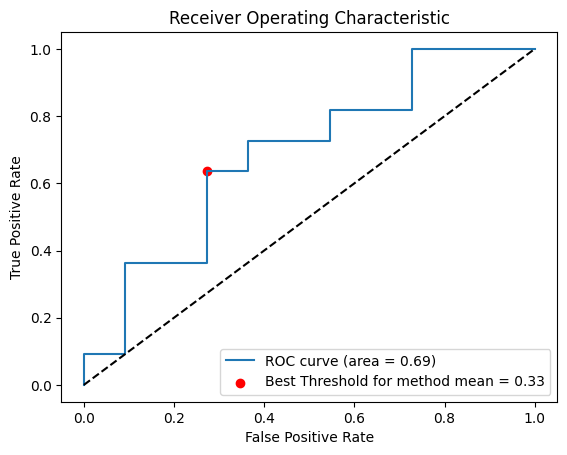

Area Under Curve: 0.6859504132231404
Best Threshold (closest to (0,1)): 0.32591142734655965


In [111]:
warnings.filterwarnings("ignore")

val_roc_results_aggregate = {}

# Getting each individual result
# 2D
val_roc_results_aggregate["2d_mean"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="mean")

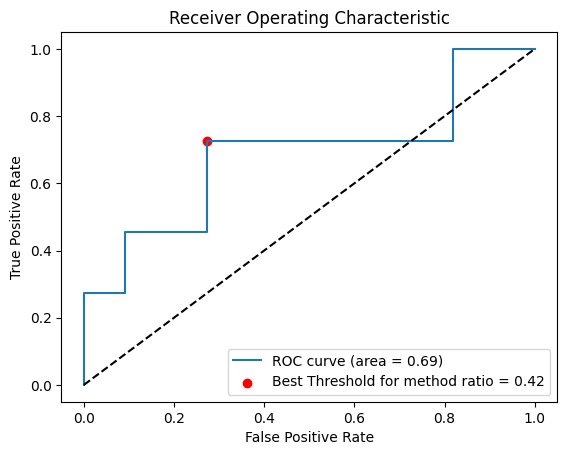

Area Under Curve: 0.6859504132231405
Best Threshold (closest to (0,1)): 0.4166666666666667


In [112]:
val_roc_results_aggregate["2d_ratio"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="ratio")

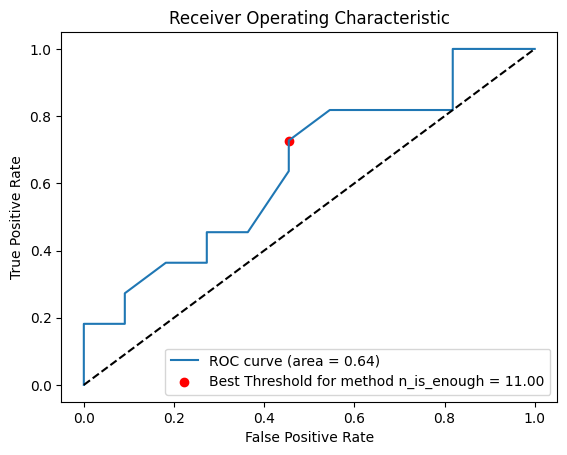

Area Under Curve: 0.6446280991735538
Best Threshold (closest to (0,1)): 11.0


In [113]:
val_roc_results_aggregate["2d_n"] = getROCAggregate(results_patient["2d"][3], val_dataset_patient, THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

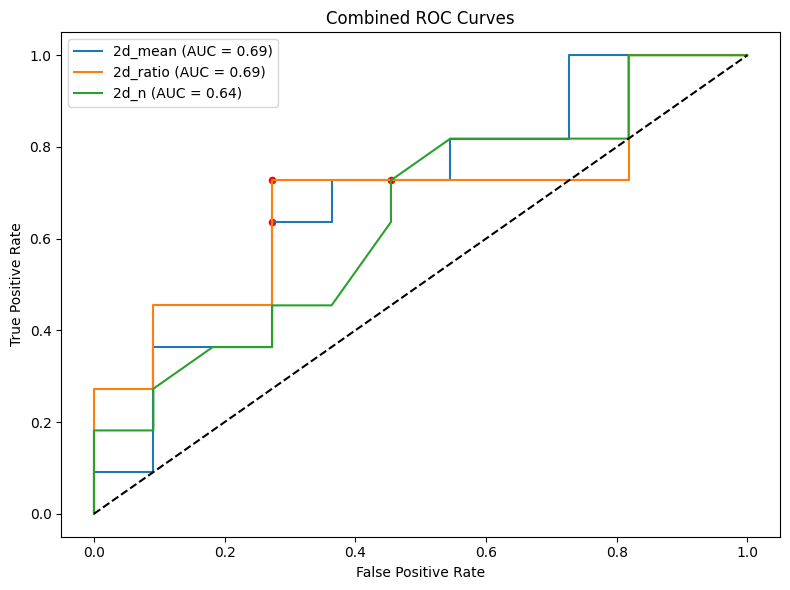

In [114]:
plt.figure(figsize=(8, 6))
for label, result in val_roc_results_aggregate.items():
    plt.plot(result["fpr"], result["tpr"], label=f'{label} (AUC = {result["auc"]:.2f})')
    plt.scatter(result["fpr"][result["best_idx"]], result["tpr"][result["best_idx"]], color='red', s=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [115]:
# Structure is mean, n_is_enough and ratio
thresholds_patient = {}
thresholds_patient["2d"] = [val_roc_results_aggregate["2d_mean"]["best_threshold"],
                             val_roc_results_aggregate["2d_n"]["best_threshold"],
                               val_roc_results_aggregate["2d_ratio"]["best_threshold"],]

<center> 

#### <span style="color:orange"> 2.5D, Patient-Wise </span>

</center>

In [116]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label, patient_id

In [117]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 908: 35__CT-1186-0010.npy
(224, 224, 3)


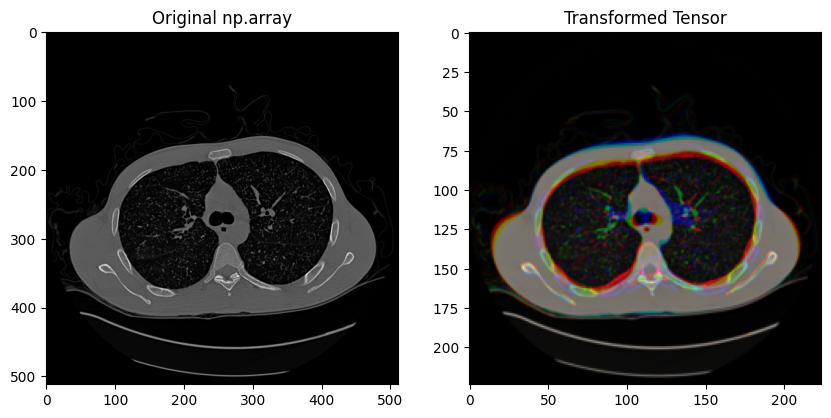

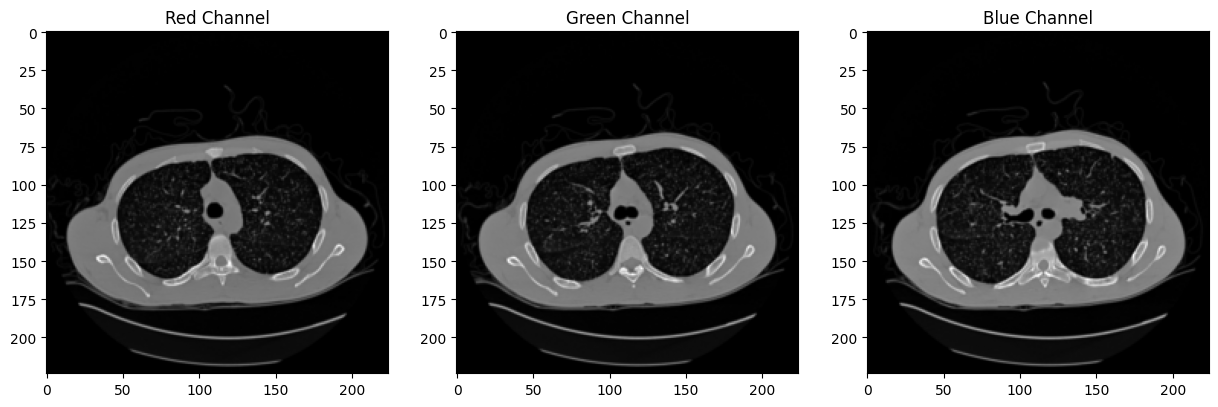

In [118]:
tensorVSnp(train_dataset, df_fibrosis)

No need to run model again. I'll simply be using the 2.5D Augmentation model.

In [119]:
results_patient["2_5d"] = results_aug["2_5d_Aug"]



<a name="22-threshold-selection-and-model-choice"></a>
### 2.3 Threshold Selection and Model Choice  



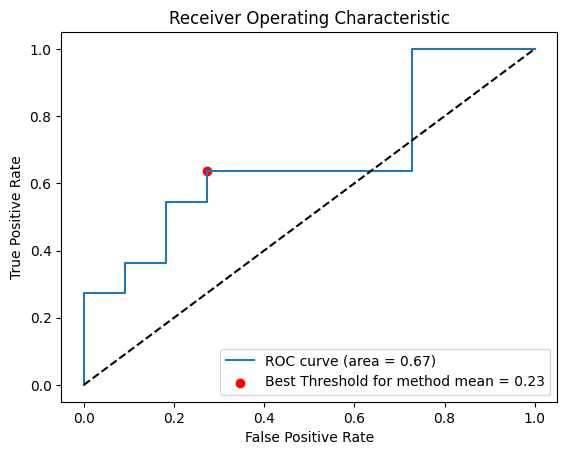

Area Under Curve: 0.6694214876033058
Best Threshold (closest to (0,1)): 0.22934986958685127


In [120]:
warnings.filterwarnings("ignore")

# Getting each individual result
# 2_5d
val_roc_results_aggregate["2_5d_mean"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="mean")

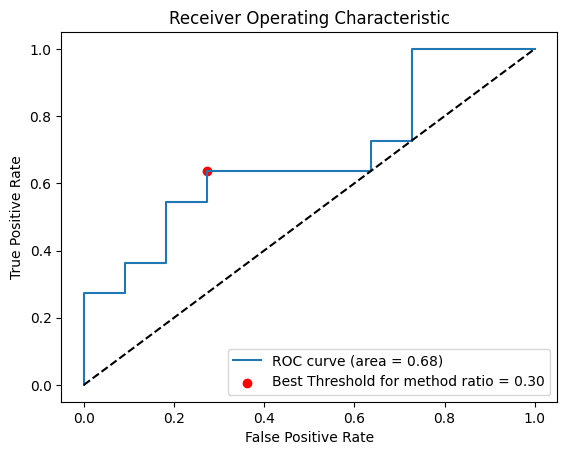

Area Under Curve: 0.6776859504132231
Best Threshold (closest to (0,1)): 0.30434782608695654


In [121]:
val_roc_results_aggregate["2_5d_ratio"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="ratio")

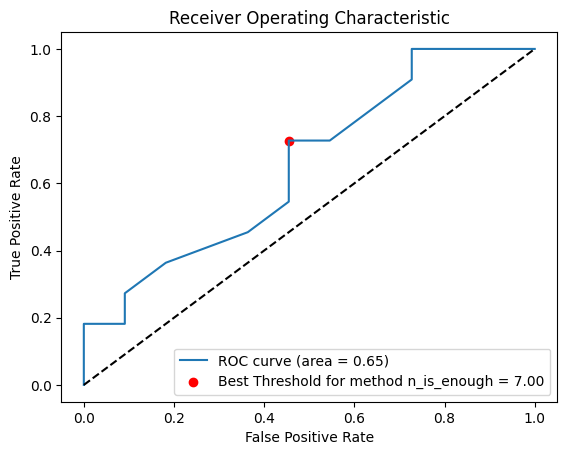

Area Under Curve: 0.6528925619834711
Best Threshold (closest to (0,1)): 7.0


In [122]:
val_roc_results_aggregate["2_5d_n"] = getROCAggregate(results_patient["2_5d"][3], val_dataset, THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

<center>

#### Validation ROC General Comparison

</center>

In [123]:
mean_compare = {k: v for k, v in val_roc_results_aggregate.items() if "mean" in k}
n_compare = {k: v for k, v in val_roc_results_aggregate.items() if "_n" in k}
ratio_compare = {k: v for k, v in val_roc_results_aggregate.items() if "ratio" in k}

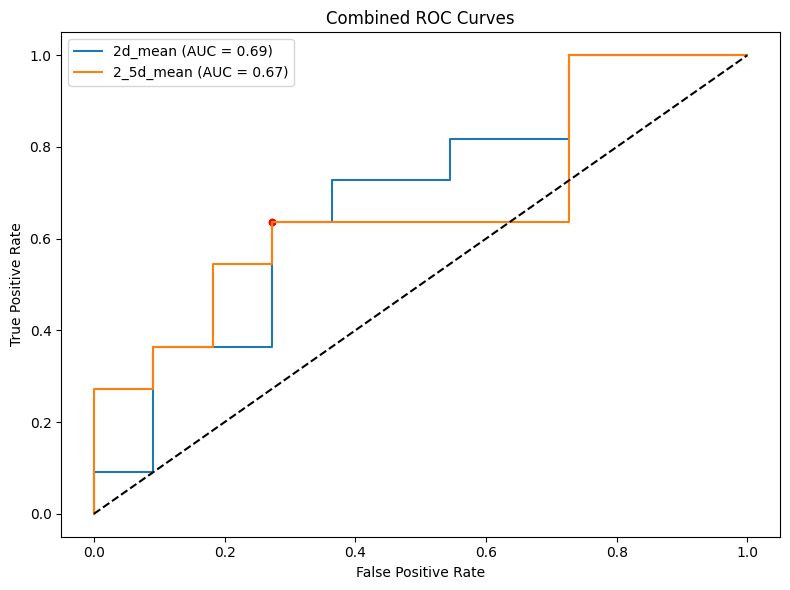

In [124]:
plotCombinedRoc(mean_compare)

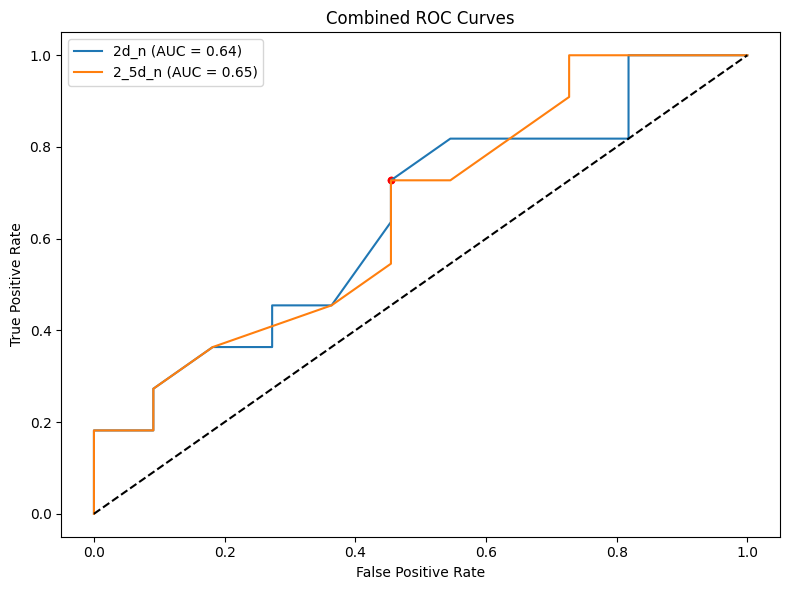

In [125]:
plotCombinedRoc(n_compare)

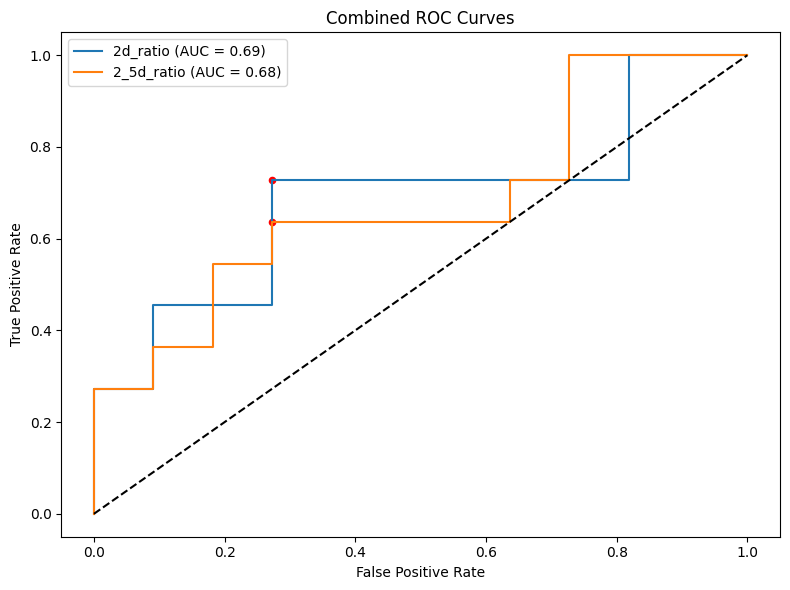

In [126]:
plotCombinedRoc(ratio_compare)

In [127]:
# Structure is mean, n_is_enough and ratio
thresholds_eval = {}
thresholds_eval["2_5d"] = [val_roc_results_aggregate["2_5d_mean"]["best_threshold"],
                             val_roc_results_aggregate["2_5d_n"]["best_threshold"],
                               val_roc_results_aggregate["2_5d_ratio"]["best_threshold"],]


<a name="24-comparison-with-2d"></a>
### 2.4 Comparison with 2D  


In [128]:
metrics_mean = {}
metrics_n = {}
metrics_ratio = {}

#### Mean

In [129]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=thresholds_eval[key][0])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=thresholds_patient[key][0])
    metrics_mean[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 71.43%  (10 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 70.60%

 --------------------- 

F1 Score (Macro): 0.704
F1 Score (Weighted): 0.710
F1 Score Class 0: 0.667
F1 Score Class 1: 0.741

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 4 10]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 64.29%  (9 in 14)
Test Accuracy: 66.67%
Weighted Accuracy: 67.62%

 --------------------- 

F1 Score (Macro

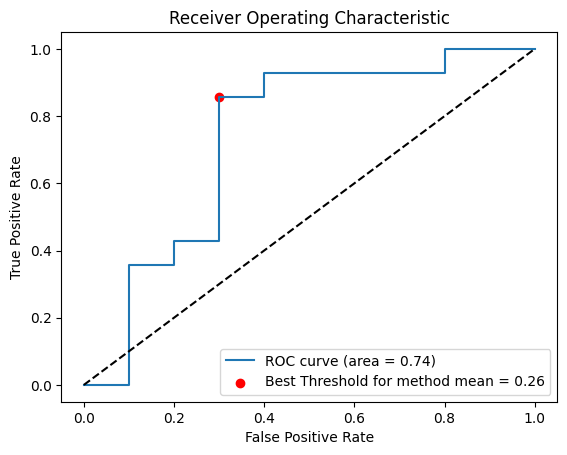

Area Under Curve: 0.7357142857142858
Best Threshold (closest to (0,1)): 0.25978996273544097


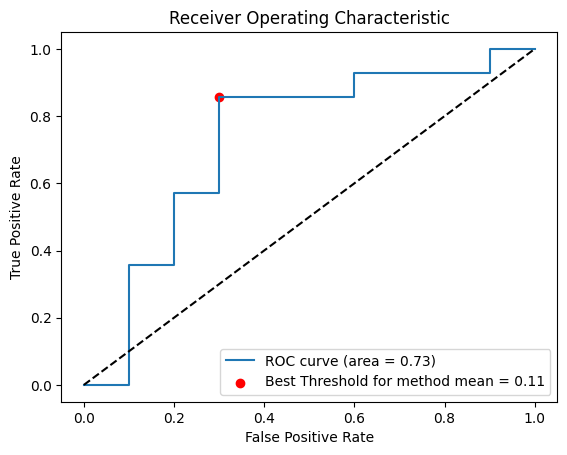

Area Under Curve: 0.7285714285714285
Best Threshold (closest to (0,1)): 0.11381719778809282


In [130]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_mean"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="mean")

test_roc_results_aggregate["2_5d_mean"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="mean", method="2_5d_")

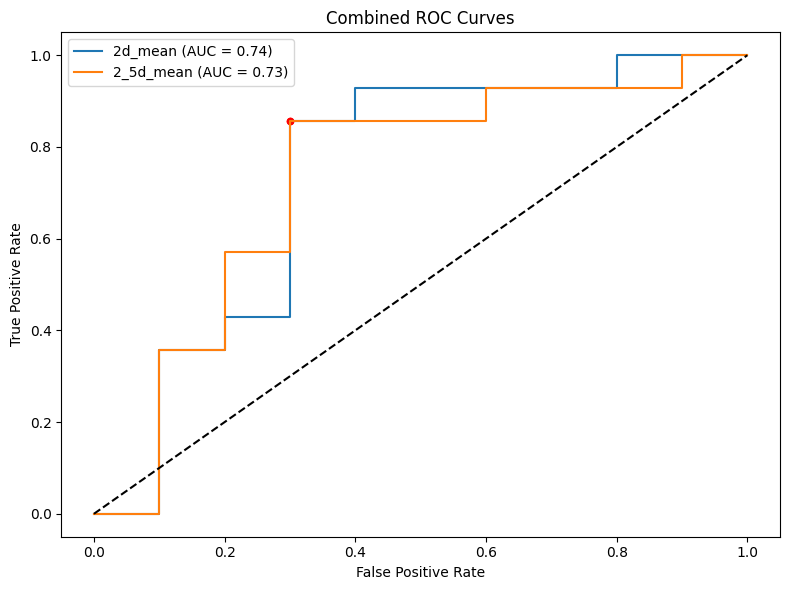

In [131]:
plotCombinedRoc(test_roc_results_aggregate)

#### Absolute Value Tests 

In [132]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"], aggregate_criteria="n_is_enough",
                                          n=thresholds_eval[key][1])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=THRESHOLD_EVAL, aggregate_criteria="n_is_enough",
                                          n=thresholds_patient[key][1])
    metrics_n[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 79.17%
Weighted Accuracy: 76.55%

 --------------------- 

F1 Score (Macro): 0.782
F1 Score (Weighted): 0.790
F1 Score Class 0: 0.737
F1 Score Class 1: 0.828

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 2 12]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 60.00%  (6 in 10)
Accuracy for Class 1: 78.57%  (11 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 67.74%

 --------------------- 

F1 Score (Macr

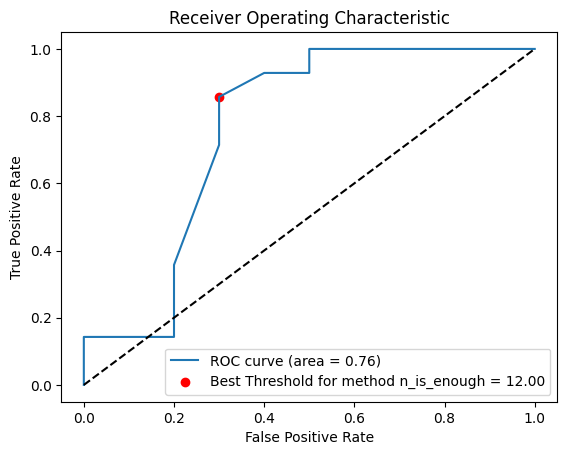

Area Under Curve: 0.7642857142857142
Best Threshold (closest to (0,1)): 12.0


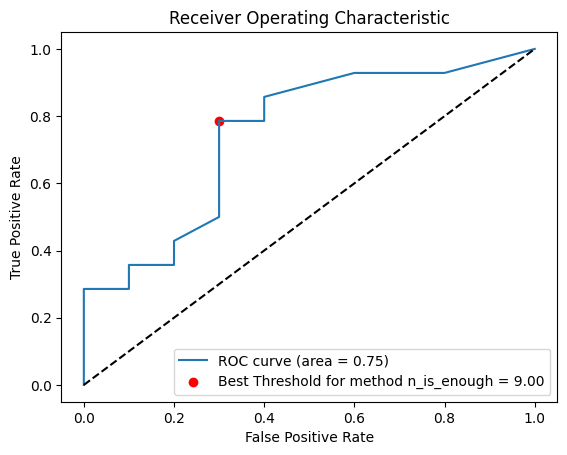

Area Under Curve: 0.7464285714285714
Best Threshold (closest to (0,1)): 9.0


In [133]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_n"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="n_is_enough")

test_roc_results_aggregate["2_5d_n"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="n_is_enough", method="2_5d_")

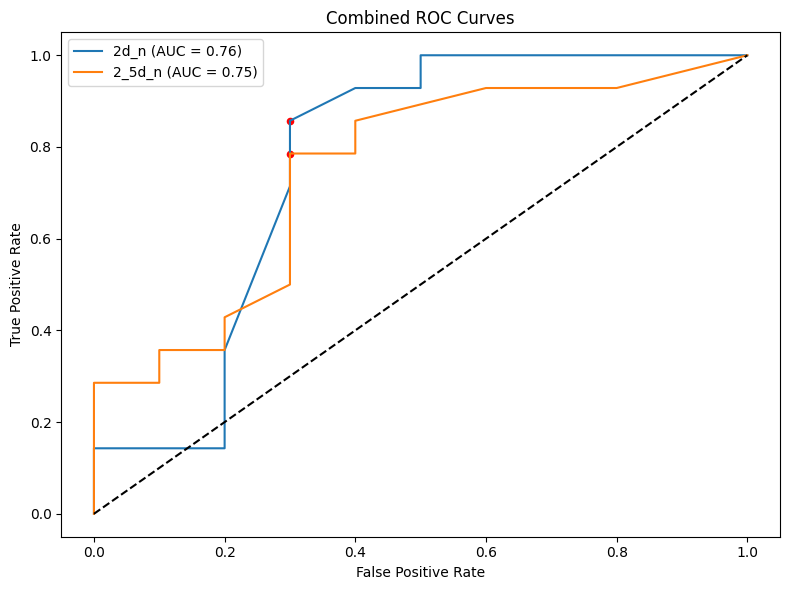

In [134]:
plotCombinedRoc(test_roc_results_aggregate)

#### Relative Value Tests

In [135]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"], aggregate_criteria="ratio",
                                          ratio=thresholds_eval[key][2])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=THRESHOLD_EVAL, aggregate_criteria="ratio",
                                          ratio=thresholds_patient[key][2])
    metrics_ratio[key] = m_patient
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 85.71%  (12 in 14)
Test Accuracy: 79.17%
Weighted Accuracy: 76.55%

 --------------------- 

F1 Score (Macro): 0.782
F1 Score (Weighted): 0.790
F1 Score Class 0: 0.737
F1 Score Class 1: 0.828

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 2 12]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 60.00%  (6 in 10)
Accuracy for Class 1: 78.57%  (11 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 67.74%

 --------------------- 

F1 Score (Macr

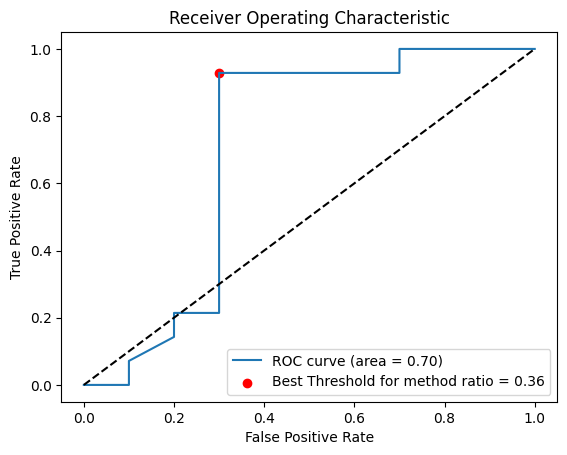

Area Under Curve: 0.7035714285714285
Best Threshold (closest to (0,1)): 0.36363636363636365


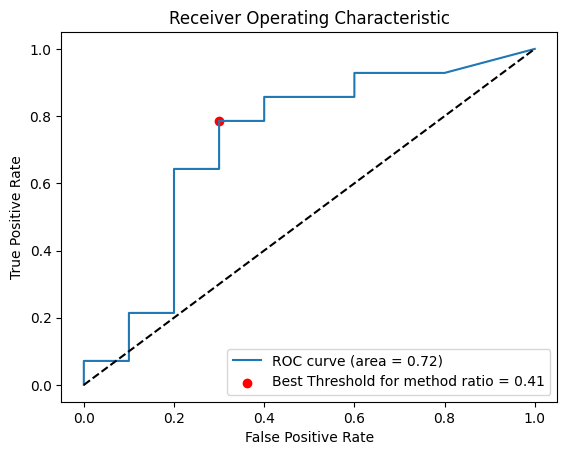

Area Under Curve: 0.7214285714285714
Best Threshold (closest to (0,1)): 0.4074074074074074


In [136]:
test_roc_results_aggregate = {}

test_roc_results_aggregate["2d_ratio"] = getROCAggregate(results_patient["2d"][3], test_dataset_patient, 
                                                        threshold=THRESHOLD_EVAL, aggregate_criteria="ratio")

test_roc_results_aggregate["2_5d_ratio"] = getROCAggregate(results_patient["2_5d"][3], test_dataset, 
                                                        threshold=val_roc_results_aug["2_5d_Aug"]["best_threshold"],
                                                          aggregate_criteria="ratio", method="2_5d_")

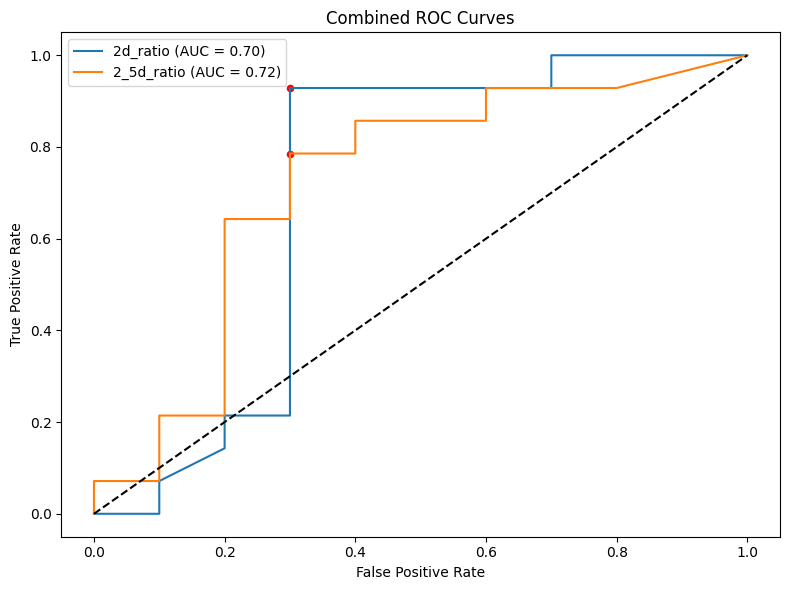

In [137]:
plotCombinedRoc(test_roc_results_aggregate)

<center>

#### Confusion Matrices

</center>

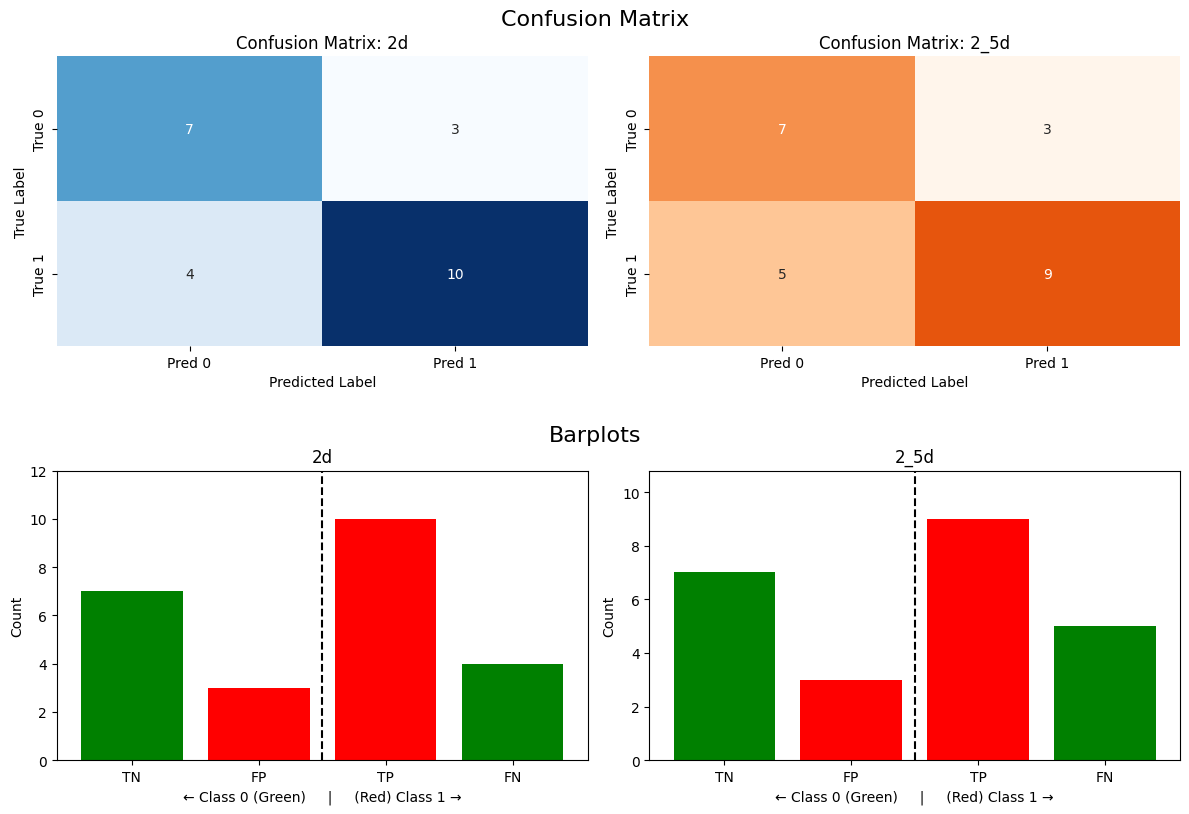

In [334]:
confMat(metrics_mean, key1="2d", key2="2_5d")

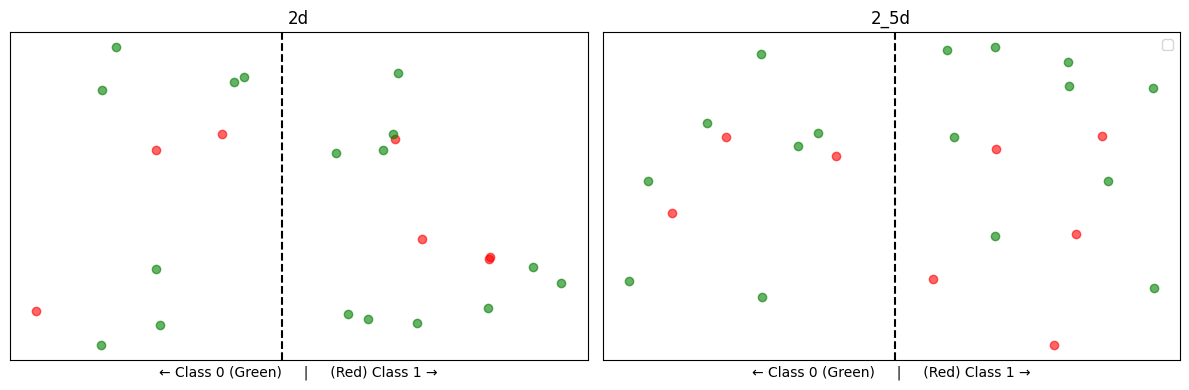

In [335]:
confMatScatter(metrics_mean, key1="2d", key2="2_5d")

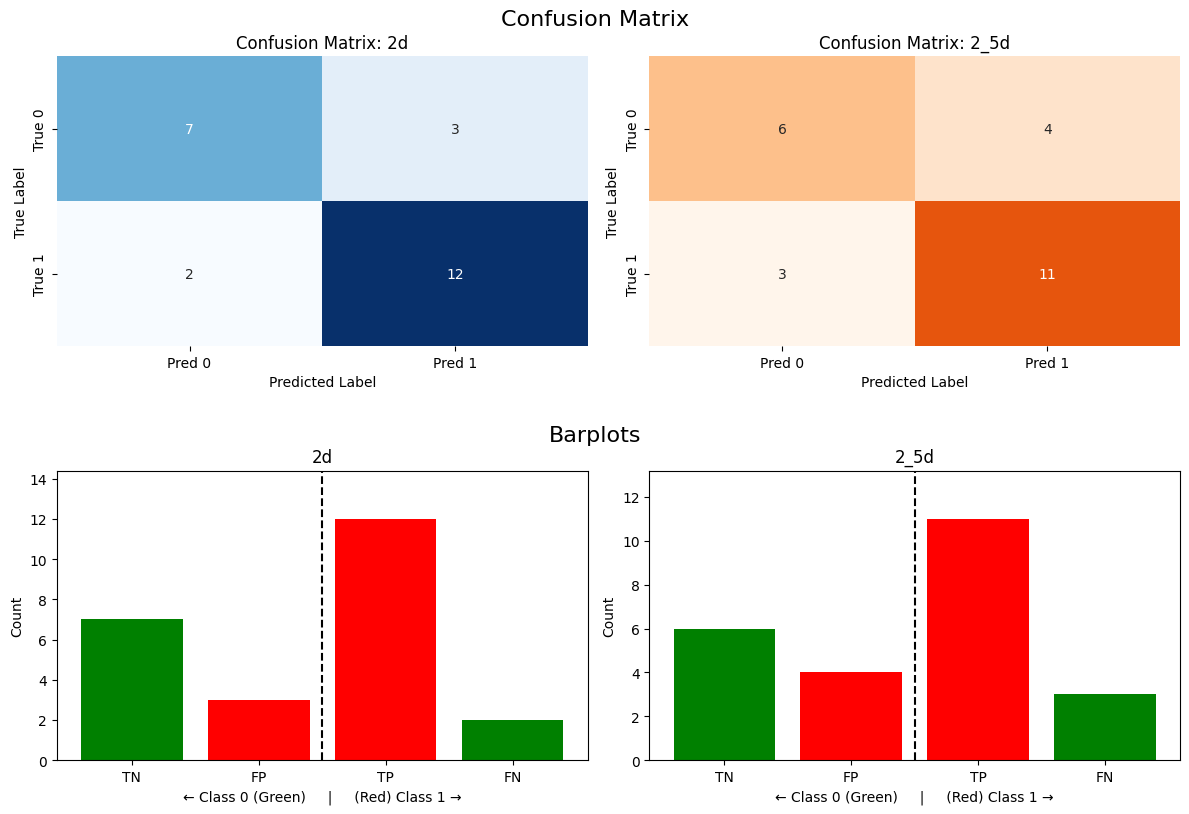

In [336]:
confMat(metrics_n, key1="2d", key2="2_5d")

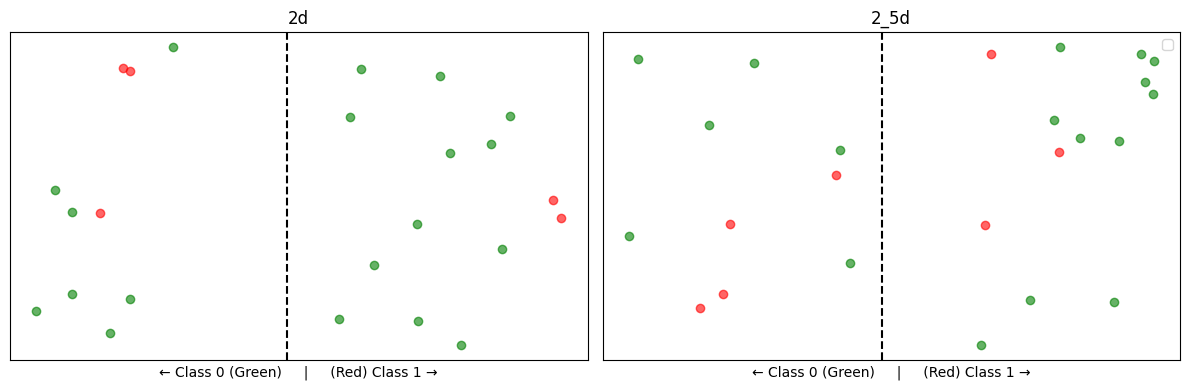

In [337]:
confMatScatter(metrics_n, key1="2d", key2="2_5d")

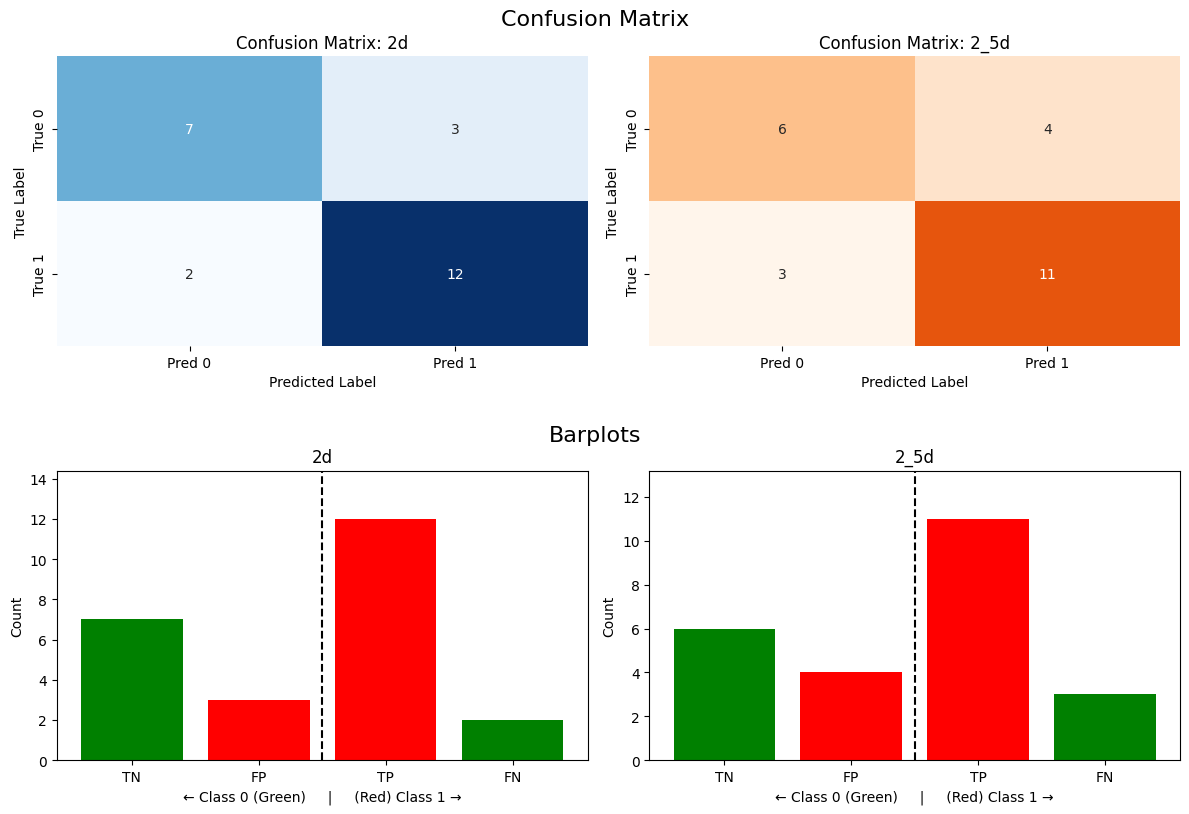

In [338]:
confMat(metrics_ratio, key1="2d", key2="2_5d")

In [ ]:
confMatScatter(metrics_n, key1="2d", key2="2_5d")

---

<a name="3-slice-level-feature-wise-classification"></a>
## 3. Slice-level Feature-wise Classification




<a name="31-concept-overview"></a>
### 3.1 Concept Overview  

For detailed information on feature extraction and visualization methods, please refer to directory `4.3 - featureExtraction`.



<a name="33-25d-execution-of-slice-level-feature-wise-classification"></a>
### 3.2 Slice-level Feature-wise Classification  


In [69]:
results_ftrs = {}

<center> 

#### <span style="color:#2377c4"> 2D Feature Extraction </span>

</center>

Not needed, results will be copied to avoid previous hassles.

<center> 

#### <span style="color:orange"> 2.5D Feature Extraction </span>

</center>

In [138]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        # idx represents index

        # Locates each image in the csv file
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")

        # Fetches entire slice name
        slice_id = self.img_labels.iloc[idx, 0]

        # Parses patient ID for each slice
        patient_id = getPatientID(slice_id)

        # Get current slice info and class
        curr_img = np.load(img_path)
        label = self.img_labels.iloc[idx, 1]


        # This function can fetch any additional slice
        def load_image(i):
            row = self.img_labels.iloc[i]
            path = os.path.join(self.img_dir, row[0])
            img = np.load(path).astype(np.float32)
            label = row[1]
            return img, label, row[0]

        
        # Fetches previous slice
        if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
            prev_img, _, _ = load_image(idx - 1)
        else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
        
        # Try to get next slice
        if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
            next_img, _, _ = load_image(idx + 1)
        else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
        
        # Finally, stacks them into RGB: shape → (3, H, W)
        image = np.stack([prev_img, curr_img, next_img], axis=0)

        # Reorder: shape → (H, W, 3)
        image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            scale_choice = random.choice(range(10,40))
            gauss_noise_choice = np.random.normal(loc=0, scale=scale_choice, size=image.shape)
            noise_stack = image + gauss_noise_choice  # NumPy broadcasting, remains np.ndarray
            
            # Gaussian Blur
            
            # random value between 1.0 and 1.5 (inclusive) in steps of 0.1
            sigma_choice = (random.choice(range(10,16))/10)

            # : : c explicitly avoids merging channels, as it only chooses each 2D array
            # essentially skips Height and Width: (H, W, 3) → acts only on "3" → each color channel
            blur_stack = np.stack(
                [gaussian_filter(image[:, :, c], sigma=sigma_choice) for c in range(3)],
                axis=2 # acts on index==2 → colors
            )

            
            # Random Choice
            gauss_choice = random.choice((0,1))
            if gauss_choice == 0: 
                #print("NOISE")
                image = noise_stack
            elif gauss_choice == 1: 
                #print("BLUR")
                image = blur_stack
            
    
        # Guarantee compatibility
        if self.gauss or self.albumentations: 
            image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        
        
                
        return image, label, patient_id

In [103]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform) #, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

SliceID at index 645: 164__CT-0002-0004.npy
(224, 224, 3)


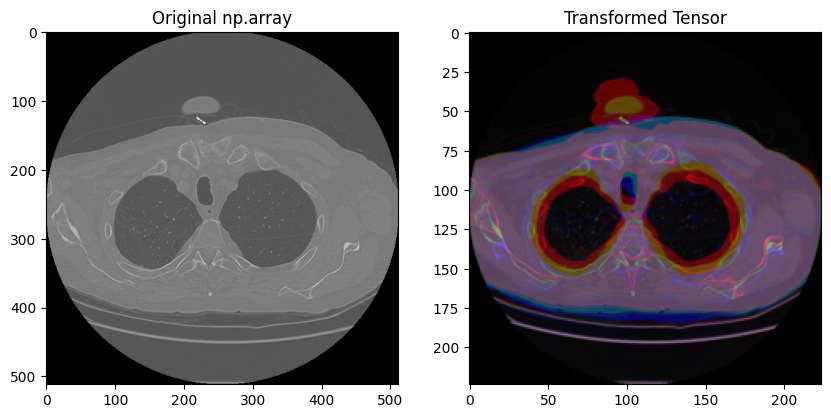

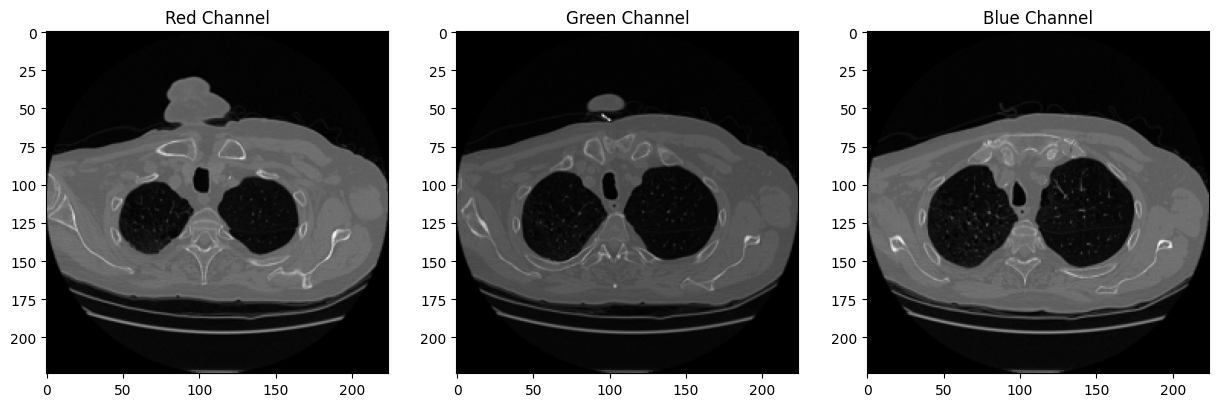

In [72]:
tensorVSnp(train_dataset, df_fibrosis)

In [78]:
features, labels, test_features, test_labels = getFeatures(results_aug["2_5d_noAug"][3], train_dataset, val_dataset, test_dataset)

Populating test features...: 100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


In [79]:
print(len(features), "slices of shape",(features[0]).shape,"for training + validation")
print(len(test_features),"slices of shape", test_features[0].shape, "for test")

2427 slices of shape torch.Size([512, 1, 1]) for training + validation
648 slices of shape torch.Size([512, 1, 1]) for test


In [80]:
features_reshaped, test_reshaped = [], []

# Each ftr is now (512,)
[features_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in features] 
[test_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in test_features] 

# For visualization purposes
print('--------------------------------------------------------------')
print("Number of slices with derived features: ", len(features_reshaped))
print("Number of total train + validation slices: ", len(train_dataset) + len(val_dataset))
print("Slice features shape: ",features_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", features_reshaped[0][:5])
print('--------------------------------------------------------------')
print("Number of test slices with derived features: ", len(test_reshaped))
print("Number of total test slices: ", len(test_dataset))
print("Slice features shape: ",test_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", test_reshaped[0][:5])
print('--------------------------------------------------------------')

--------------------------------------------------------------
Number of slices with derived features:  2427
Number of total train + validation slices:  2427
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([0.7046, 0.0982, 0.3093, 1.0501, 0.8804])
--------------------------------------------------------------
Number of test slices with derived features:  648
Number of total test slices:  648
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([0.7653, 0.1256, 0.3456, 1.0879, 1.2536])
--------------------------------------------------------------


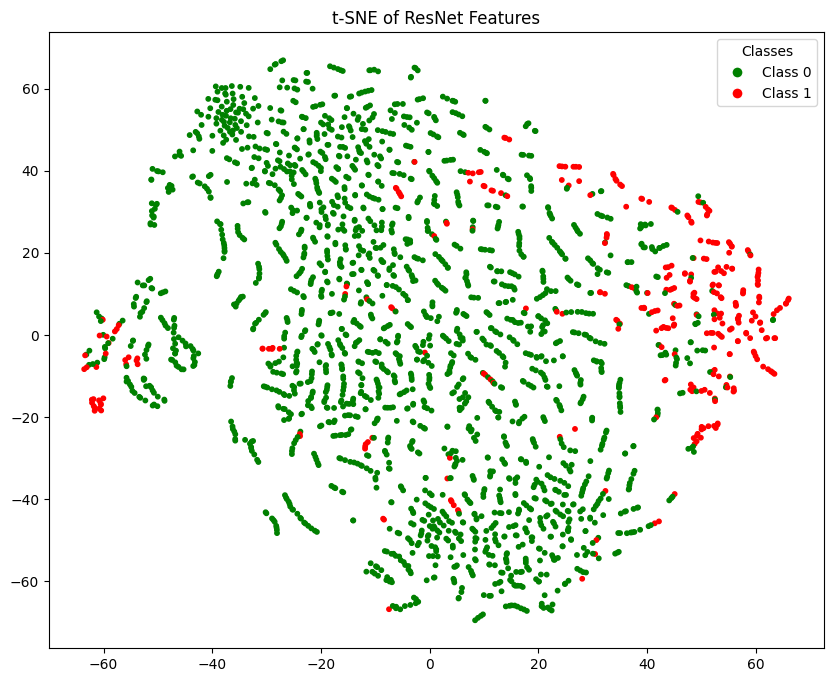

In [81]:
plotTSNE(features_reshaped, labels)

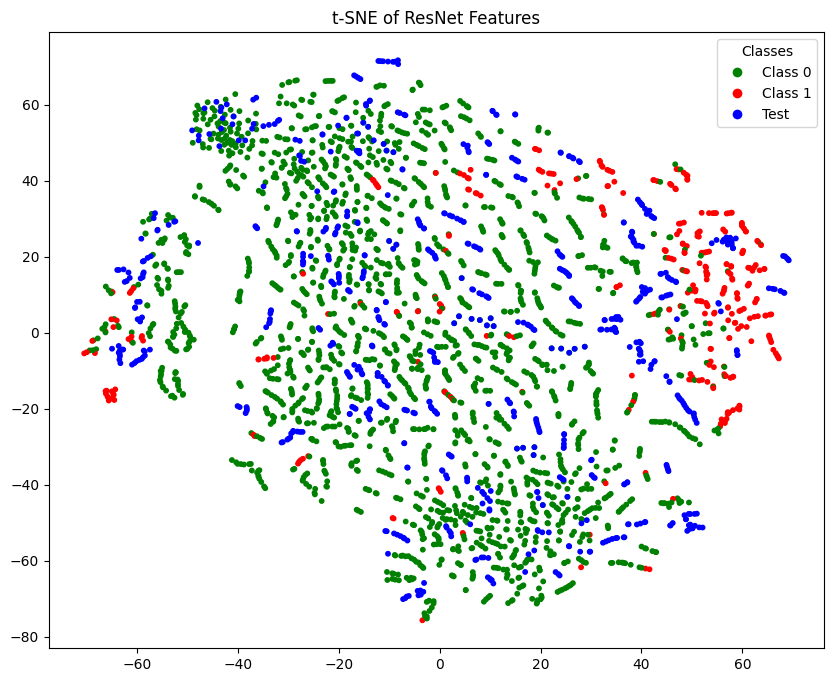

In [82]:
plotTSNE(features_reshaped, labels, test_features)

#### EXTRAS: Manifestation Plots

In [83]:
# Setup
root = r"..\\..\\..\\fibrosis_dataset\ILD_DB_txtROIs"
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

train_ds = pd.read_csv(annotations_file_train)
val_ds = pd.read_csv(annotations_file_val)

manifest_dict = searchDiffManifest(root,verbose=0)

full_df = pd.concat([train_ds, val_ds], ignore_index=True)

manifest_df = manifestationDataframe(manifest_dict, full_df)

⚠️ Warning: Folder '12' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8871' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8873' not found in datasets.
⚠️ Warning: Folder '108' not found in datasets.
⚠️ Warning: Folder '150' not found in datasets.
⚠️ Warning: Folder '155' not found in datasets.
⚠️ Warning: Folder '157' not found in datasets.


121__CT-0844-0010.npy is not class 1!!!
107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!


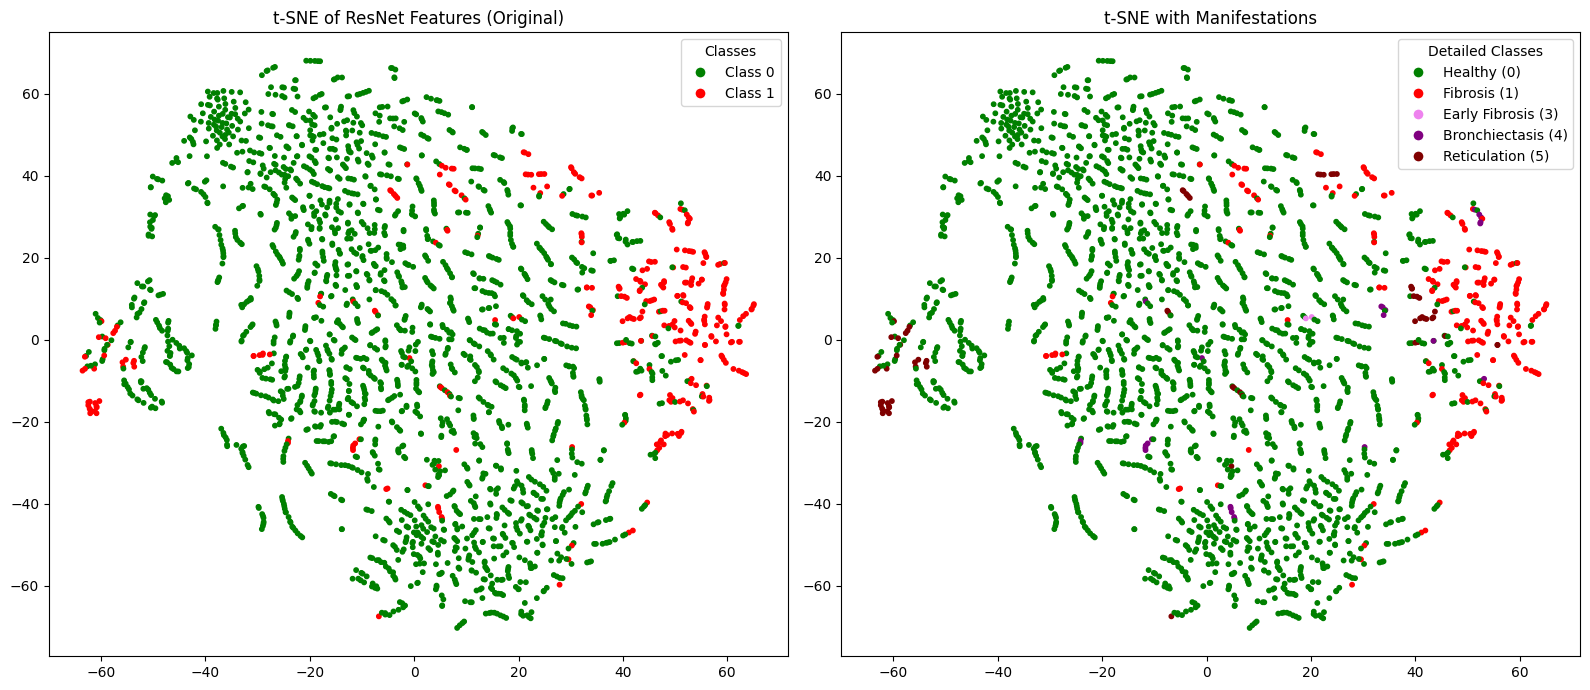

In [84]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False)

121__CT-0844-0010.npy is not class 1!!!
107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!


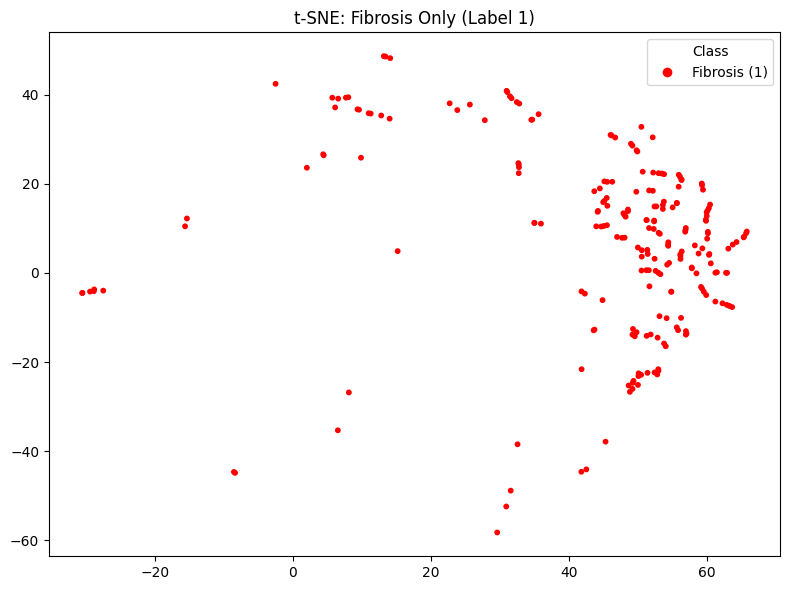

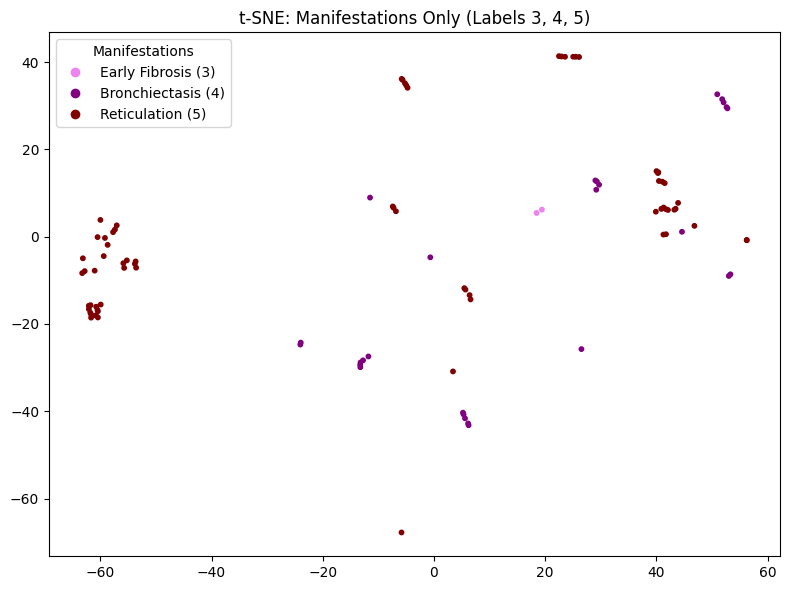

In [85]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False, mask=True)




<a name="32-threshold-selection-and-model-choice"></a>
### 3.3 Threshold Selection and Model Choice  




Testing for best k...: 100%|██████████| 512/512 [03:18<00:00,  2.58it/s]


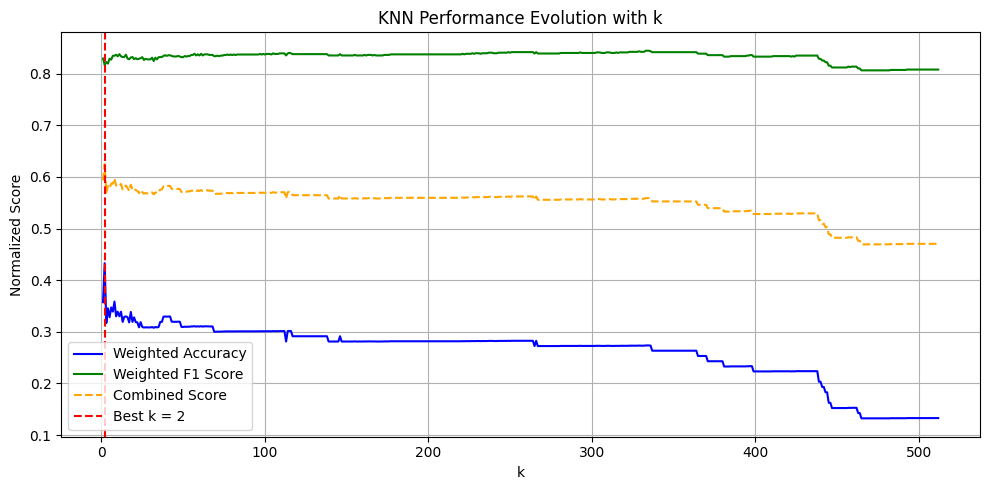

In [86]:
k_list_euclid, w_acc_list_euclid, w_f1_list_euclid = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=i,verbose=0)
    k_list_euclid.append(k_i)
    w_acc_list_euclid.append(weighted_acc_i)
    w_f1_list_euclid.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_euclid, w_acc_list_euclid, w_f1_list_euclid)

Testing for best k...: 100%|██████████| 512/512 [03:48<00:00,  2.24it/s]


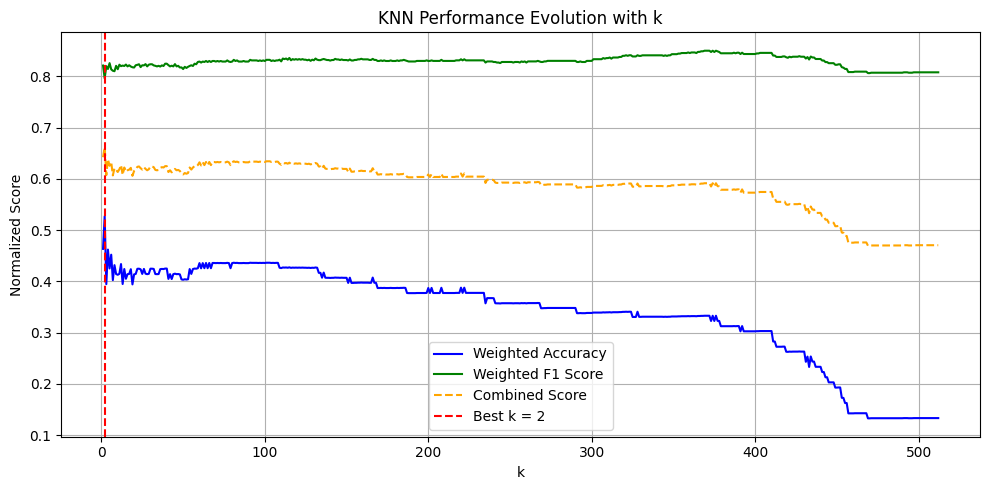

In [87]:
k_list_cosine, w_acc_list_cosine, w_f1_list_cosine = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels, criteria="cosine",k=i,verbose=0)
    k_list_cosine.append(k_i)
    w_acc_list_cosine.append(weighted_acc_i)
    w_f1_list_cosine.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_cosine, w_acc_list_cosine, w_f1_list_cosine)


<a name="34-comparison-with-2d"></a>
### 3.4 Comparison with 2D  


In [88]:
metrics_euclid = {}
metrics_cosine = {}
metrics_mahal = {}

#### Euclidean Performance

In [90]:
print("                            Eucliean Distance Performance for k=2                            ")
m_euclid = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=2)

                            Eucliean Distance Performance for k=2                            

 --------------------- 

Accuracy for Class 0: 87.74%  (494 in 563)
Accuracy for Class 1: 36.47%  (31 in 85)
Test Accuracy: 81.02%
Weighted Accuracy: 43.29%

 --------------------- 

F1 Score (Macro): 0.612
F1 Score (Weighted): 0.817
F1 Score Class 0: 0.889
F1 Score Class 1: 0.335

 --------------------- 


Confusion Matrix: 
 [[494  69]
 [ 54  31]]


#### Cosine Performance

In [91]:
print("                            Cosine Distance Performance for k=8                            ")
m_cosine = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="cosine",k=2)

                            Cosine Distance Performance for k=8                            

 --------------------- 

Accuracy for Class 0: 81.71%  (460 in 563)
Accuracy for Class 1: 48.24%  (41 in 85)
Test Accuracy: 77.31%
Weighted Accuracy: 52.69%

 --------------------- 

F1 Score (Macro): 0.610
F1 Score (Weighted): 0.796
F1 Score Class 0: 0.862
F1 Score Class 1: 0.358

 --------------------- 


Confusion Matrix: 
 [[460 103]
 [ 44  41]]


#### Mahalanobis Performance

In [92]:
m_mahal = featuresKNN_CPU(features_reshaped, labels, test_reshaped, test_labels,criteria="mahalanobis")

Length of class1: 324


Computing mahalanobis distances... : 100%|██████████| 648/648 [01:24<00:00,  7.68it/s]

Total examples: 648

 --------------------- 

Accuracy for Class 0: 61.81%  (348 in 563)
Accuracy for Class 1: 80.00%  (68 in 85)
Test Accuracy: 64.20%
Weighted Accuracy: 77.58%

 --------------------- 

F1 Score (Macro): 0.560
F1 Score (Weighted): 0.700
F1 Score Class 0: 0.750
F1 Score Class 1: 0.370

 --------------------- 


Confusion Matrix: 
 [[348 215]
 [ 17  68]]


Old values:

```py

metrics_euclid["2d"] = [0.8472, 0.5176, 0.8040, 0.5615,
                        0.646, 0.820, 0.883, 0.409, None]

metrics_cosine["2d"] = [0.8526, 0.6000, 0.8194, 0.6336,
                         0.679, 0.836, 0.891, 0.466, None]

metrics_mahal["2d"] = [0.8615, 0.5294, 0.8179, 0.5736,
                        0.662, 0.831, 0.892, 0.433, None]

```

In [93]:
metrics_euclid["2d"] = [0.8455, 0.5529, 0.8071, 0.5918, 0.657, 
                        0.824, 0.884, 0.429, [[476, 87], [38, 47]]]

metrics_cosine["2d"] = [0.8295, 0.5765, 0.7963, 0.6101, 0.651,
                         0.817, 0.876, 0.426, [[467, 96], [36, 49]]]

metrics_mahal["2d"] = [0.9183, 0.3647, 0.8457, 0.4383, 0.647, 
                       0.842, 0.912, 0.383, [[517, 46], [54, 31]]]

In [94]:
metrics_euclid["2_5d"] = m_euclid
metrics_cosine["2_5d"] = m_cosine
metrics_mahal["2_5d"] = m_mahal

<center>

#### Confusion Matrices

</center>

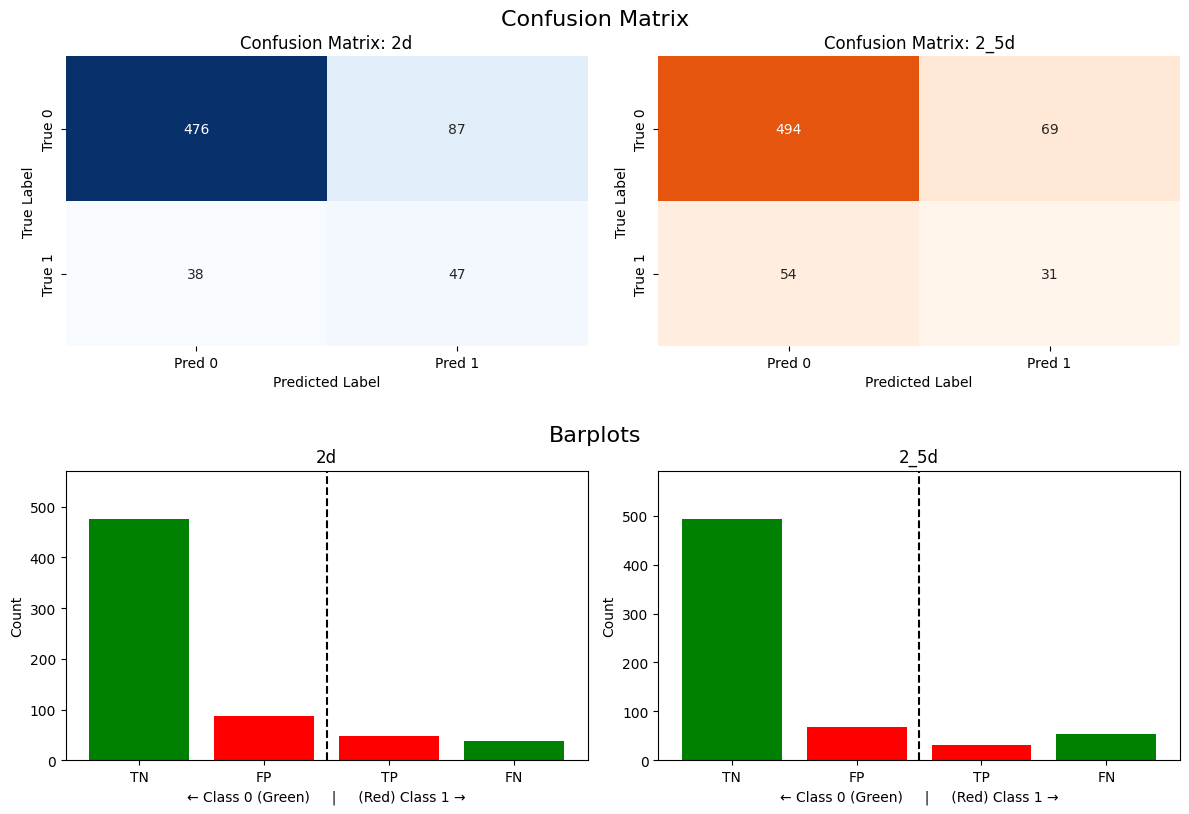

In [339]:
confMat(metrics_euclid, key1="2d", key2="2_5d")

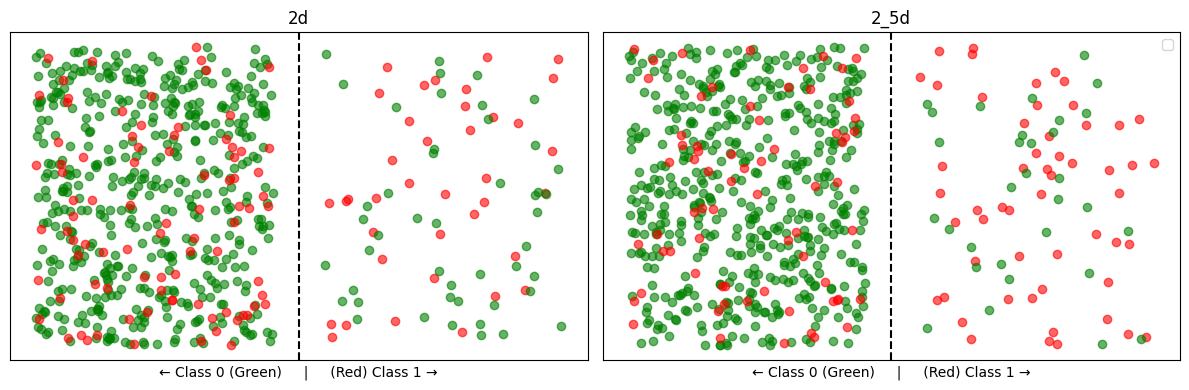

In [340]:
confMatScatter(metrics_euclid, key1="2d", key2="2_5d")

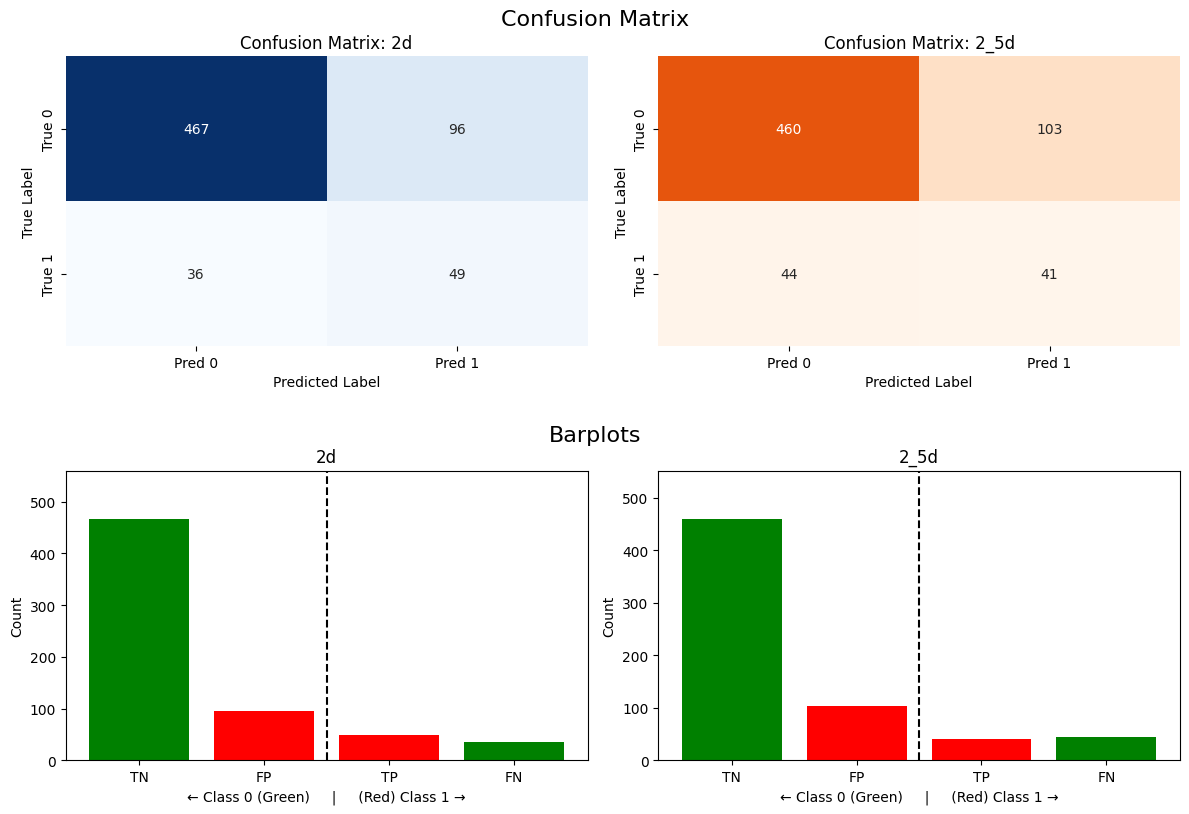

In [341]:
confMat(metrics_cosine, key1="2d", key2="2_5d")

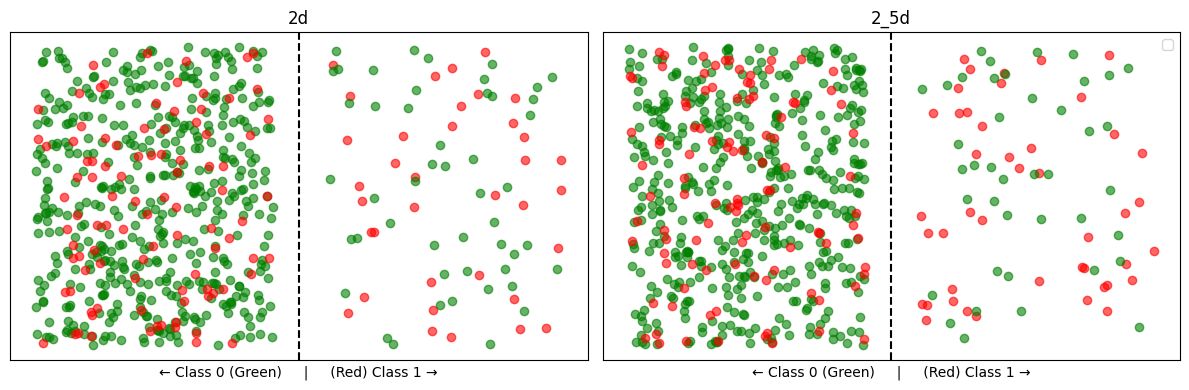

In [342]:
confMatScatter(metrics_cosine, key1="2d", key2="2_5d")

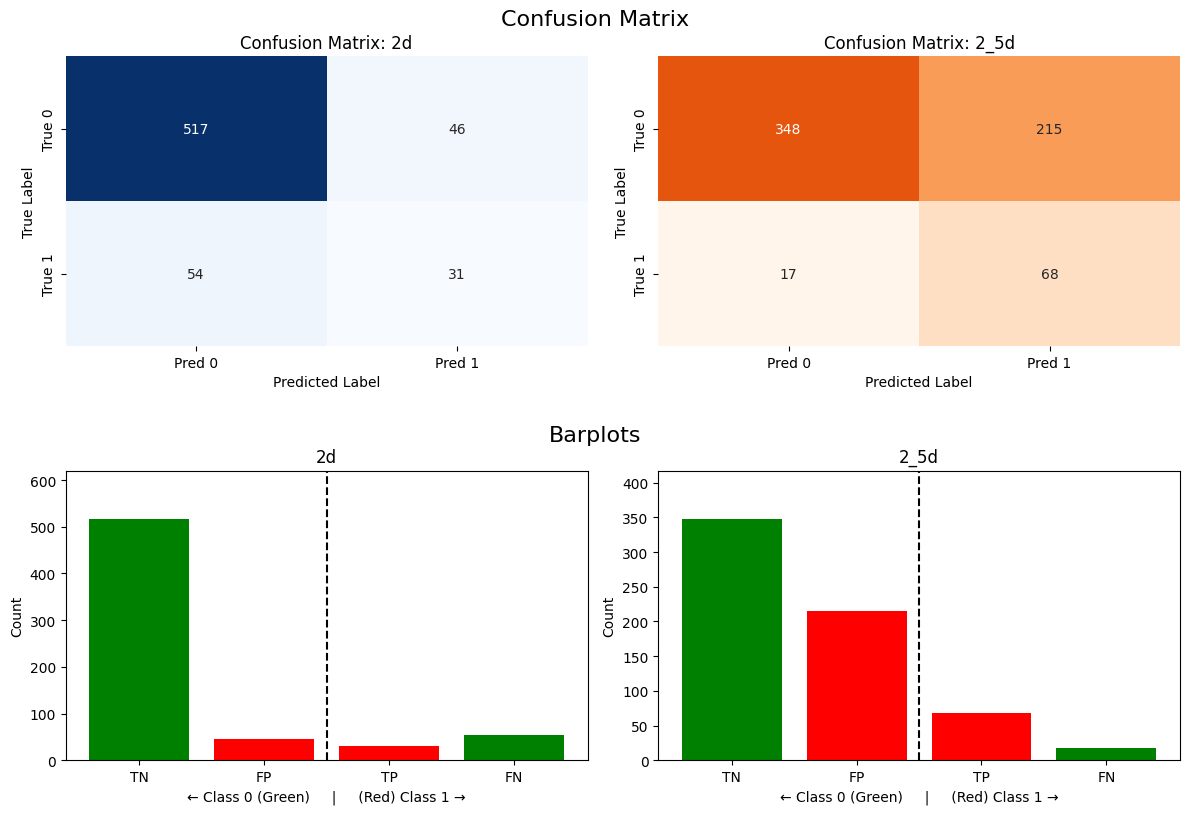

In [343]:
confMat(metrics_mahal, key1="2d", key2="2_5d")

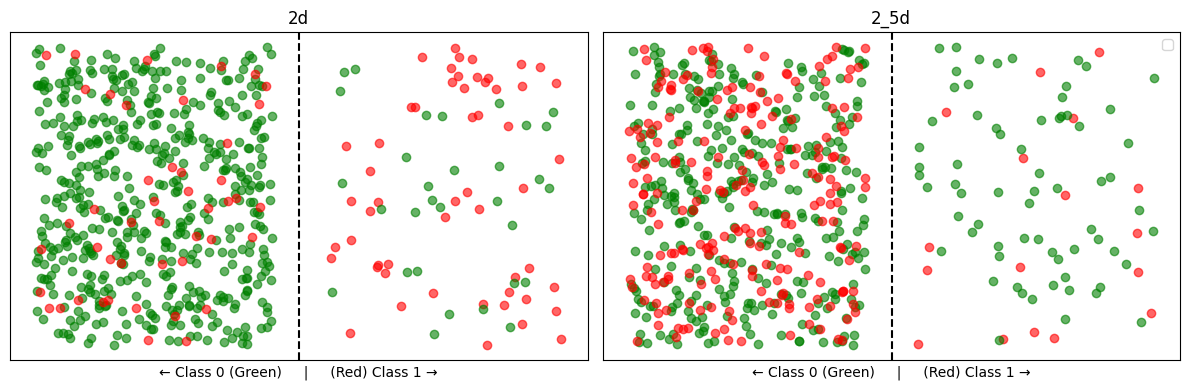

In [344]:
confMatScatter(metrics_mahal, key1="2d", key2="2_5d")

---

<a name="4-conclusion"></a>

## 4. Conclusion 


### 4.1 Methodology for Plots

The metrics dictionaries follow the structure below:

```py

metrics_topic[method] = [accuracy_class_0, accuracy_class_1, accuracy, weighted_accuracy,
                         f1_macro, f1_weighted, f1_class_0, f1_class_1, conf_mat] 

```

For simplicity of result analysis, I decided to create side-by-side barplots for 2D vs 2.5D:

In [345]:
# Auxiliary function, helps creating 2 barplots in 1 plot
def plotGroup(group_dict, title, subplot_index, metric_labels):
    methods = list(group_dict.keys())
    values = [group_dict[m][:8] for m in methods]  # Exclude conf_mat
    num_metrics = len(metric_labels)
    x = np.arange(num_metrics)

    width = 0.8 / len(methods)  # Dynamic bar width

    plt.subplot(2, 1, subplot_index)
    for i, (method, vals) in enumerate(zip(methods, values)):
        # Choose color based on method name
        #color = 'red' if '_5' in method else '#2377c4'
        plt.bar(x + i * width, vals, width=width, label=method) #, color=color)

    plt.xticks(x + width * (len(methods) - 1) / 2, metric_labels, rotation=45)
    plt.ylabel("Score")
    plt.title(title, fontsize=14, pad=20)  # Increase font size and space below title
    plt.legend()
    plt.tight_layout(pad=8.0)  # Adjust spacing between subplots

    

def barPlotCollection(metrics_dict, title2, title1=None):
    # Define metric labels (excluding conf_mat for plotting)
    metric_labels = [
        "Class 0 \nAccuracy", "Class 1 \nAccuracy", "Accuracy", "Weighted \nAccuracy",
        "F1 Macro", "F1 Weighted", "F1 Class 0", "F1 Class 1"
    ]
    
    #if len(metrics_dict.keys()) > 2:
    # Split methods into 'no' and 'others'
    methods_with_no = {k: v for k, v in metrics_dict.items() if "no" in k.lower()}
    methods_others = {k: v for k, v in metrics_dict.items() if "no" not in k.lower()}
    
    
    plt.figure(figsize=(12, 10))

    if methods_with_no:
        plotGroup(
            methods_with_no,
            title1,
            1,
            metric_labels
        )

    if methods_others:
        plotGroup(
            methods_others,
            title2,
            2 if methods_with_no else 1,
            metric_labels
        )    


        plt.tight_layout()
        plt.show()

<center> 

### Augmentations

</center>

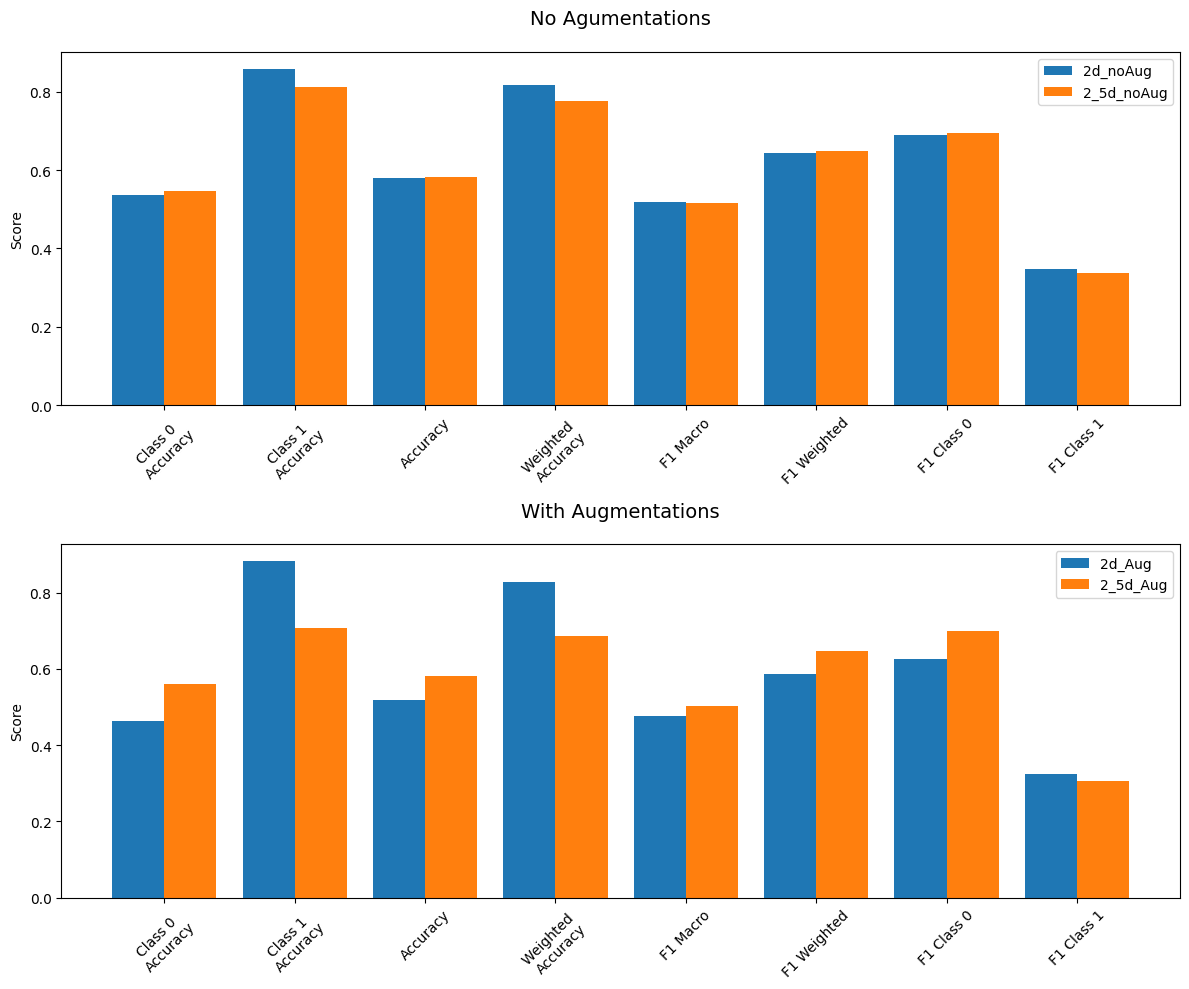

In [346]:
barPlotCollection(metrics_aug, "With Augmentations", "No Agumentations",)

<center> 

### Patient Aggregation: Mean

</center>

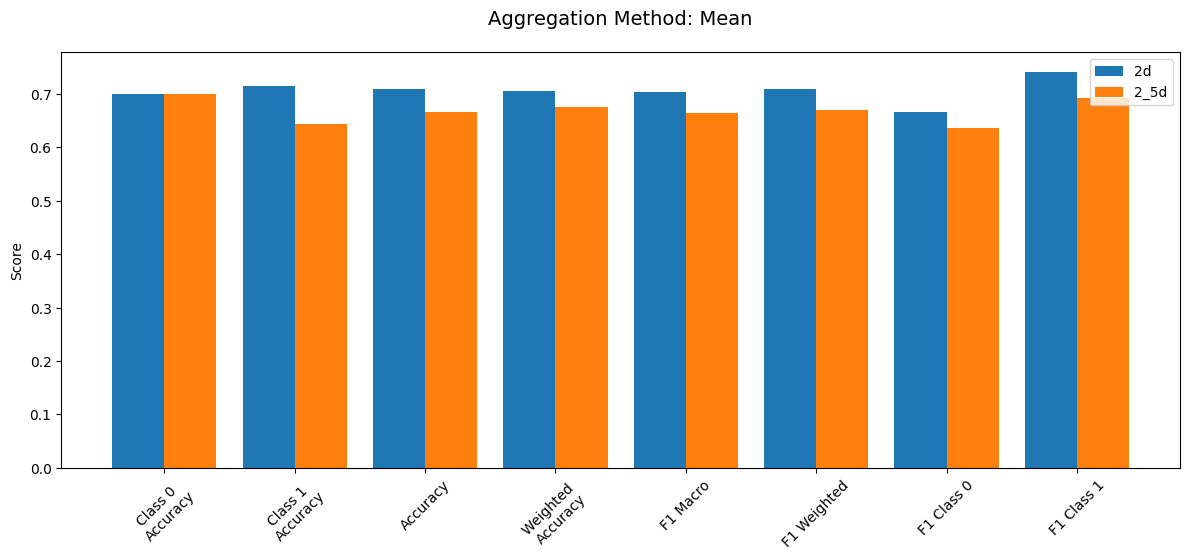

In [347]:
barPlotCollection(metrics_mean, "Aggregation Method: Mean")

<center> 

### Patient Aggregation: N_is_enough

</center>

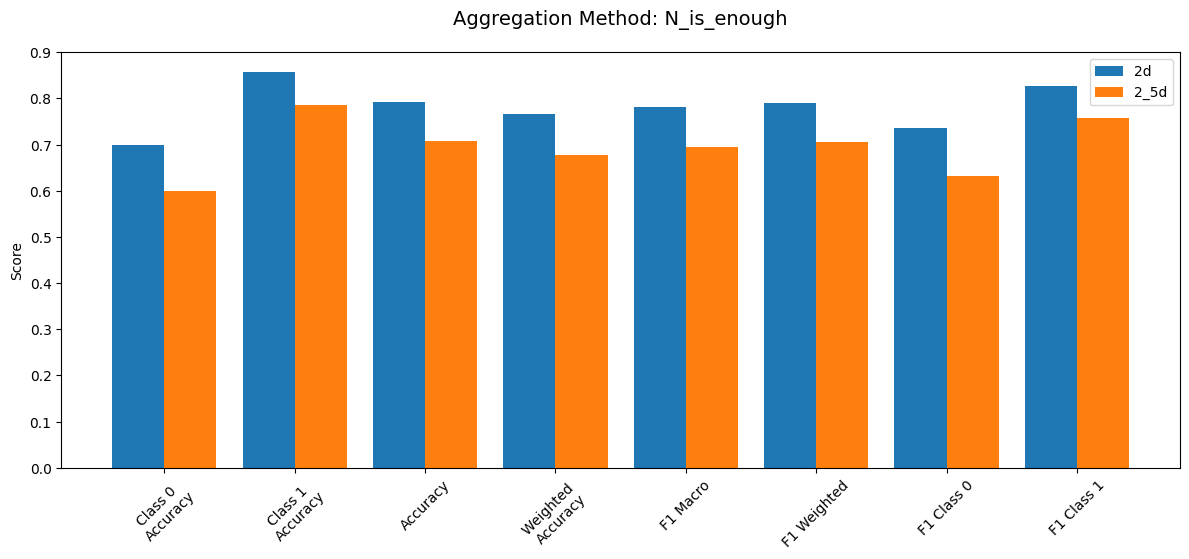

In [348]:
barPlotCollection(metrics_n, "Aggregation Method: N_is_enough")

<center> 

### Patient Aggregation: Ratio

</center>

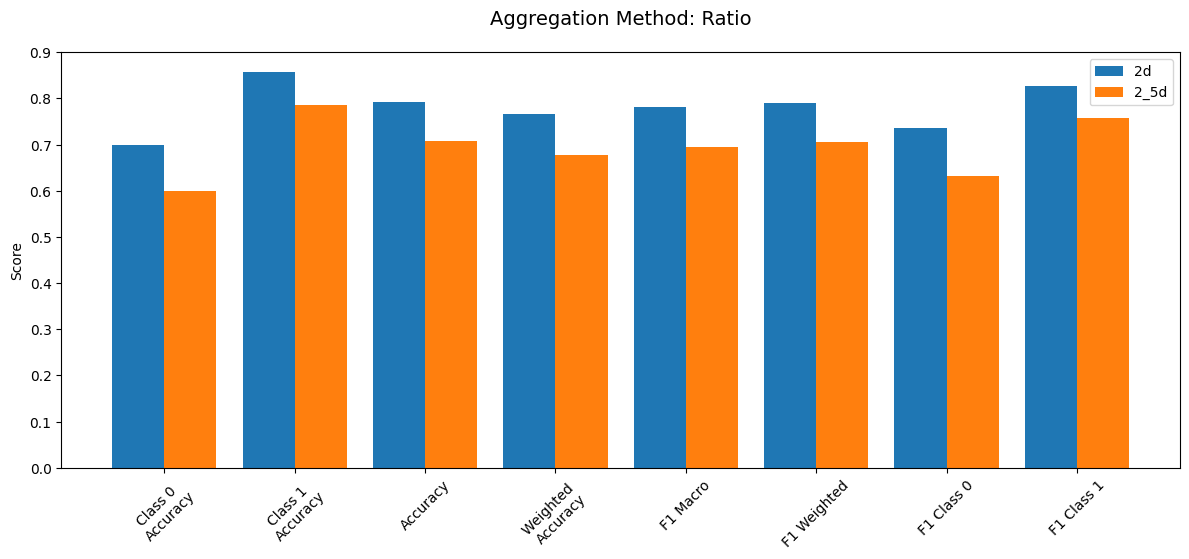

In [349]:
barPlotCollection(metrics_ratio, "Aggregation Method: Ratio")

<center> 

### Feature Extraction: Euclidean

</center>

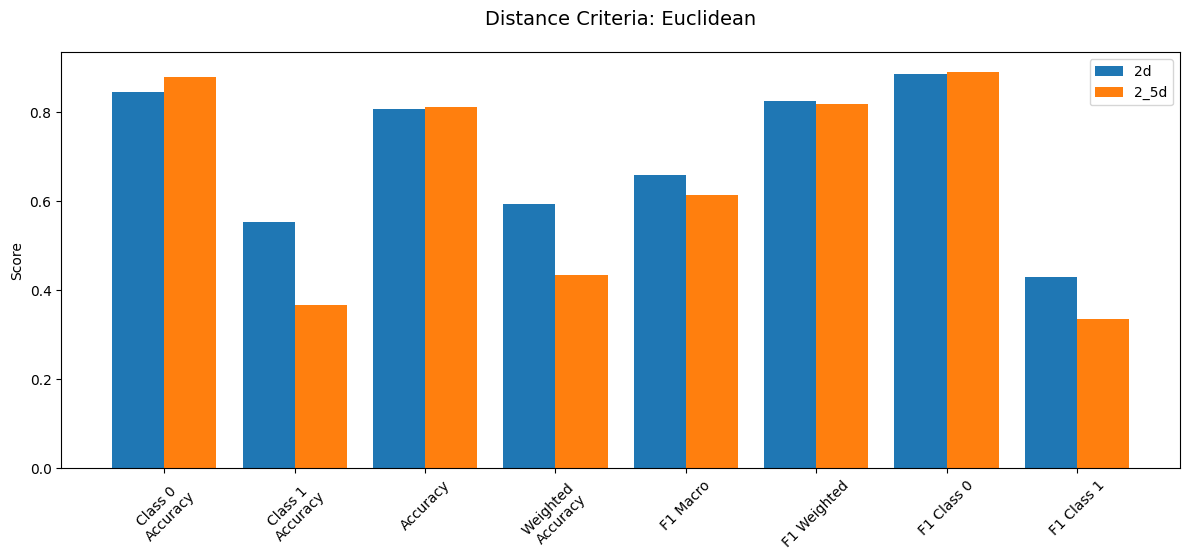

In [350]:
barPlotCollection(metrics_euclid, "Distance Criteria: Euclidean")

<center> 

### Feature Extraction: Cosine

</center>

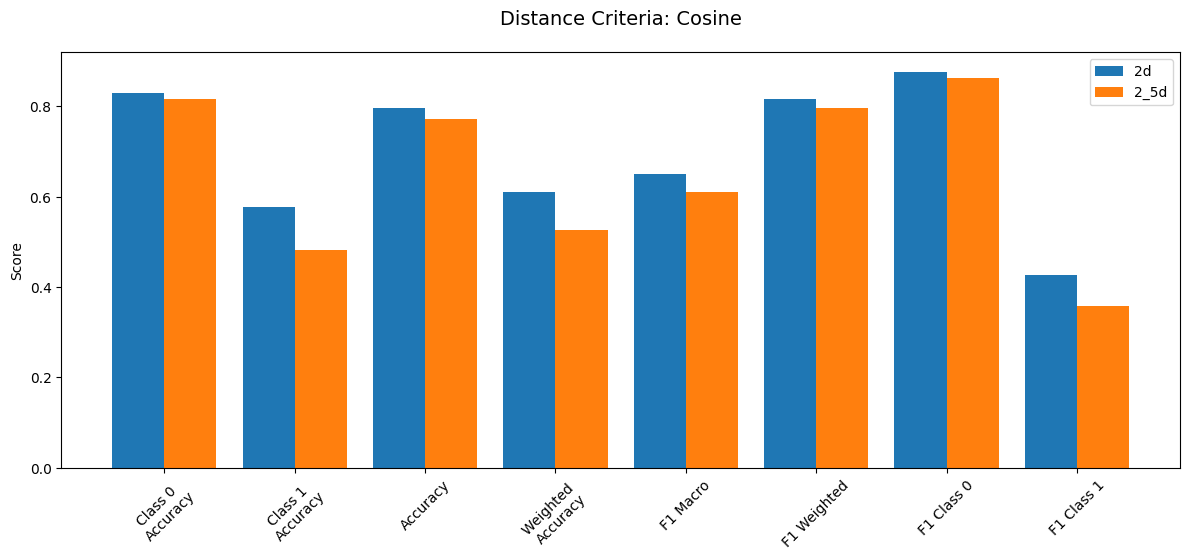

In [351]:
barPlotCollection(metrics_cosine, "Distance Criteria: Cosine")

<center> 

### Feature Extraction: Mahalanobis

</center>

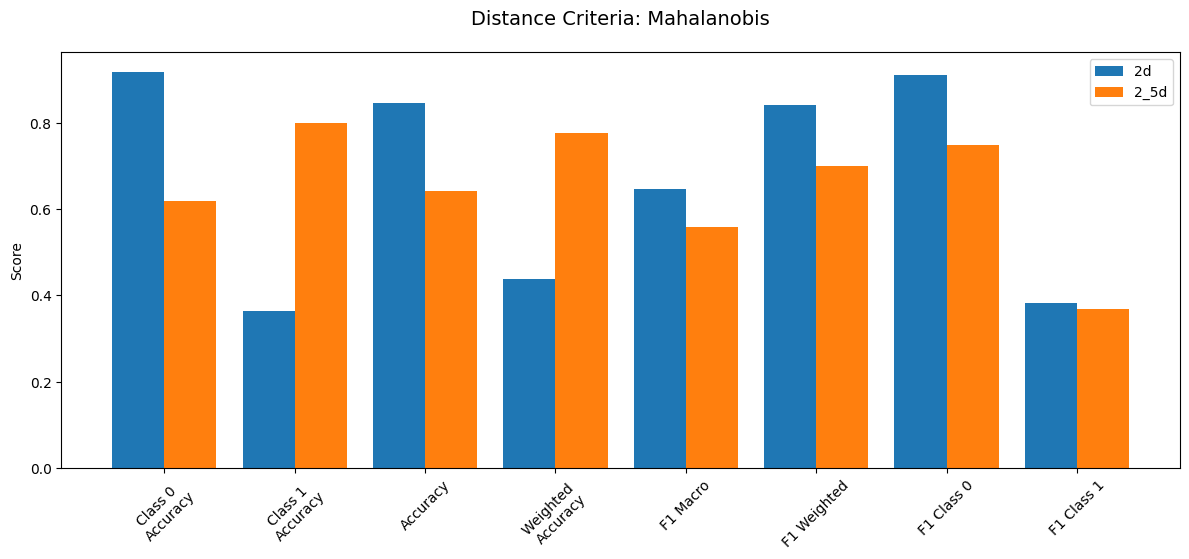

In [352]:
barPlotCollection(metrics_mahal, "Distance Criteria: Mahalanobis")